# Import Libraries

In [24]:
%matplotlib inline
import sys
sys.path.append("/home/felix/PycharmProjects/vae-wavefunctions/")
# from utils.general_prep import *
# from utils.qcvae_prep import *
from utils.vae import *
from utils.vae_viz import * 
import json
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import numpy as np
import gc 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Define VAE

In [34]:
# n_points = 20001
# n_samples = 4
# rho_arr = np.load('/home/felix/PycharmProjects/vae-wavefunctions/data/sic/unitary_4x4_200001_4.npy', mmap_mode="r")
# scan_arr = np.linspace(0, np.pi, n_points)

# n_points = 21
# n_samples = 11350
# rho_arr = np.load('/home/felix/PycharmProjects/vae-wavefunctions/data/sic/unitary_4x4_21_11350.npy', mmap_mode="r")
# scan_arr = np.linspace(0, np.pi, n_points)

n_points = 101
n_samples = 1000
rho_arr = np.load('/home/felix/PycharmProjects/vae-wavefunctions/data/sic/unitary_4x4_101_1000_no.npy', mmap_mode="r")
scan_arr = np.linspace(0, np.pi, n_points)

batch_size = 64
beta = 0.01
n_epoch = 3
learning_rate = 0.001
lat_dim = 2
use_ramp = True
# hidden_act = "leaky_relu"
# final_act = "tanh"

hidden_act = "tanh"
final_act = "linear"



theta_arr = np.zeros(len(rho_arr))
cnt = 0
for theta in scan_arr:
        for _ in (range(n_samples)):
            theta_arr[cnt] = theta
            cnt += 1

X_train, X_test, y_train, y_test = train_test_split(rho_arr, theta_arr, random_state=42)

In [36]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_val_loss', factor=0.2,
                                                     patience=100, min_lr=0.0001)

class Kl_Ramp(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if use_ramp:
            vae_model.beta_pre = np.tanh(2*epoch/(n_epoch//2))
        else:
            1
        
        
        
encoder, decoder = vae_mlp_4x4(lat_dim, hidden_act, final_act)
vae_model = VAE(encoder, decoder, beta)
vae_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

train_gen = train_generator(X_train, batch_size)
val_gen = test_generator(X_test, batch_size)

history_dict = vae_model.fit(train_gen, steps_per_epoch=X_train.shape[0] // batch_size, epochs=n_epoch, verbose=0,
                             validation_data=val_gen, validation_steps=X_test.shape[0] // batch_size,
                             callbacks=[reduce_lr, Kl_Ramp()])

# z_mean, z_log_var, z = vae_model.encoder.predict(X_test)
# gc.collect()

In [ ]:
q_ee = [ qt.entropy_vn(qt.Qobj(z0.reshape(4,4),dims=[[2,2],[2,2]]).ptrace(0)) for z0 in X_test]

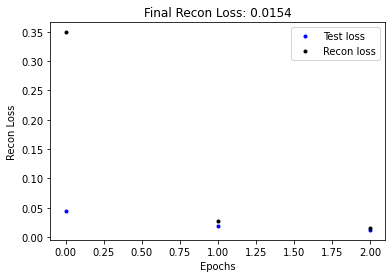

In [37]:
fig, ax1 = plt.subplots()

ax1.plot(history_dict.history["val_val_loss"],".",label="Test loss", color="blue")
ax1.plot(history_dict.history["reconstruction_loss"],".",label="Recon loss", color="black")
# ax1.plot(history_dict.history["kl_loss"],".",label="Recon loss")


ax1.set_xlabel('Epochs')
ax1.set_ylabel('Recon Loss', color='black')

plt.title("Final Recon Loss: " + str(np.round(history_dict.history["reconstruction_loss"][-1],4)))
plt.legend()
plt.show()

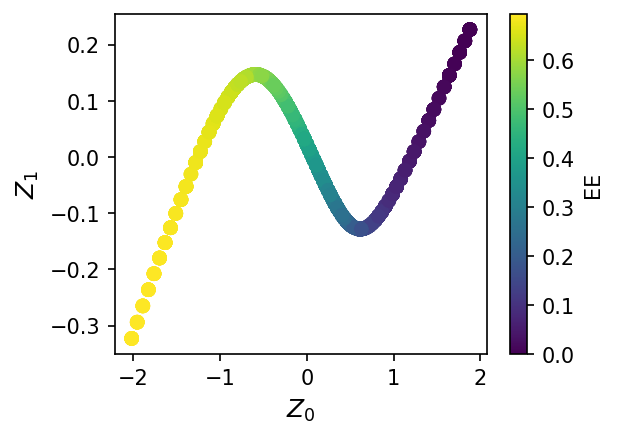

In [27]:
plot_scatter(z_mean[:,0],z_mean[:,1],q_ee,"$Z_0$","$Z_1$","EE",1)

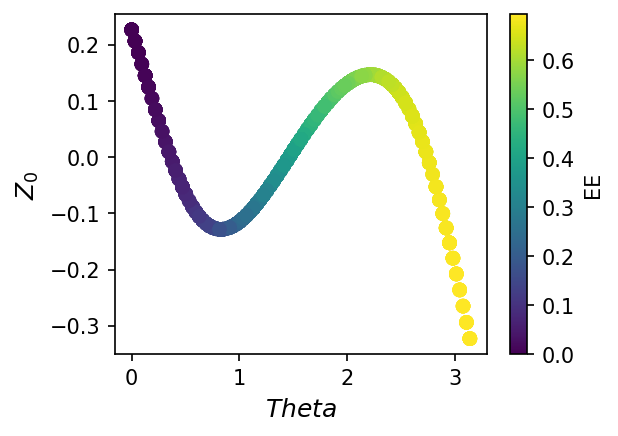

In [30]:
plot_scatter(y_test,z_mean[:,1],q_ee,"$Theta$","$Z_0$","EE",1)

# Analyze Cluster Results

In [42]:
# n_points = 81
# n_samples = 7
# rho_arr = np.load('/home/felix/PycharmProjects/vae-wavefunctions/data/sic/unitary_8x8_81_7.npy', mmap_mode="r")
# scan_arr = np.linspace(0, np.pi, n_points)

n_points = 101
n_samples = 1000
rho_arr = np.load('/home/felix/PycharmProjects/vae-wavefunctions/data/sic/unitary_4x4_101_1000.npy', mmap_mode="r")
scan_arr = np.linspace(0, np.pi, n_points)

batch_size = 64
beta = 0.0#75
n_epoch = 1
learning_rate = 0.005
lat_dim = 2

hidden_act = "tanh"
final_act = "linear"


theta_arr = np.zeros(len(rho_arr))
cnt = 0
for theta in scan_arr:
        for _ in (range(n_samples)):
            theta_arr[cnt] = theta
            cnt += 1

X_train, X_test, y_train, y_test = train_test_split(rho_arr, theta_arr, random_state=42)
q_ee = [ qt.entropy_vn(qt.Qobj(z0.reshape(4,4),dims=[[2,2],[2,2]]).ptrace(0)) for z0 in X_test]

In [50]:
encoder, decoder = vae_mlp_4x4(lat_dim, hidden_act, final_act)
# encoder.load_weights("/home/felix/Downloads/leiden_cluster/dm4x4/noise_beta/encoder_1_1001_mlp.h5")
# decoder.load_weights("/home/felix/Downloads/leiden_cluster/dm4x4/noise_beta/decoder_1_1001_mlp.h5")

# encoder.load_weights("/home/felix/Downloads/leiden_cluster/dm4x4/noise_no_beta/encoder_1_1000_mlp.h5")
# decoder.load_weights("/home/felix/Downloads/leiden_cluster/dm4x4/noise_no_beta/decoder_1_1000_mlp.h5")

encoder.load_weights("/home/felix/Downloads/leiden_cluster/dm4x4/encoder_0_noise.h5")
decoder.load_weights("/home/felix/Downloads/leiden_cluster/dm4x4/decoder_0_noise.h5")

# encoder.load_weights("/home/felix/Downloads/leiden_cluster/dm4x4/noise_multiple_beta/encoder_2_01_mlp.h5")
# decoder.load_weights("/home/felix/Downloads/leiden_cluster/dm4x4/noise_multiple_beta/decoder_2_01_mlp.h5")

vae = VAE(encoder, decoder, beta)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
vae.fit(X_test[:2], epochs=1, batch_size=1, verbose=1) 

z_mean, z_log_var, z = vae.encoder.predict(X_test)
gc.collect()

2/2 [==============================] - 1s 2ms/step - loss: 0.0019 - reconstruction_loss: 0.0023 - kl_loss: 31.0676


28623

# Explain Symmetry


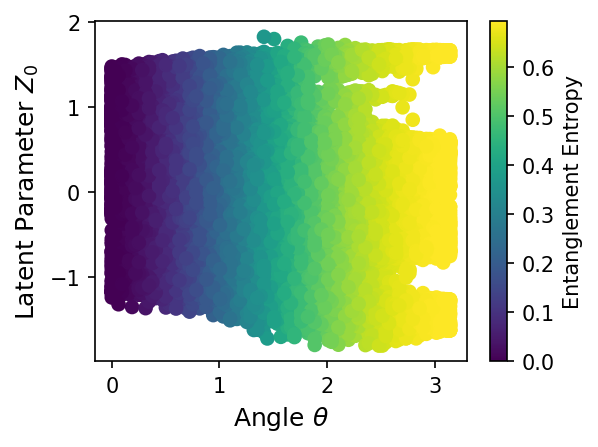

In [52]:
# q_ee = [ qt.entropy_vn(qt.Qobj(z0.reshape(4,4),dims=[[2,2],[2,2]]).ptrace(0)) for z0 in X_test]
def plot_scatter(m_0, m_1, labels, title_x, title_y, title_cbar, alpha):
    fig, ax = plt.subplots(figsize=(4, 3),dpi=150)
    im = ax.scatter(m_0, m_1, c=labels, alpha=alpha)
    ax.set_xlabel(title_x, fontsize=12)
    ax.set_ylabel(title_y, fontsize=12)
    cbar = fig.colorbar(im)
    cbar.set_label(title_cbar)
    plt.show()
plot_scatter(y_test,z_mean[:,0],q_ee,"Angle $\\theta$","Latent Parameter $Z_0$","Entanglement Entropy",1)

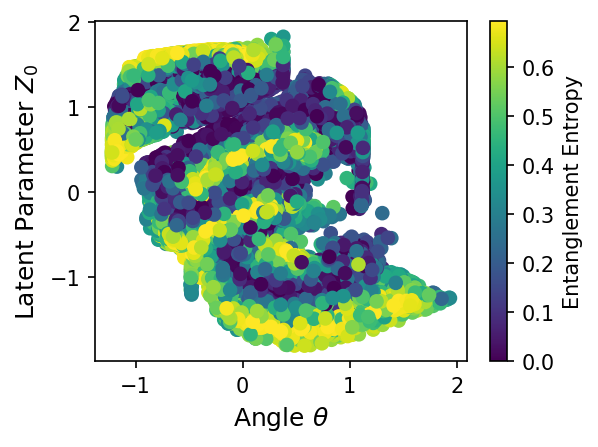

In [53]:
plot_scatter(z_mean[:,1],z_mean[:,0],q_ee,"Angle $\\theta$","Latent Parameter $Z_0$","Entanglement Entropy",1)

In [16]:
neg_pred = []
pos_pred = []

neg_z = []
pos_z = []

neg_theta = []
pos_theta = []


cnt = 0 
for i in z_mean[:,0]:
    if i < 0:
        neg_pred.append(X_test[cnt])
        neg_z.append(i)
        neg_theta.append(y_test[cnt])
        
    else:
        pos_pred.append(X_test[cnt])
        pos_z.append(i)
        pos_theta.append(y_test[cnt])
    cnt += 1 
    
# neg_pred = decoder.predict(np.array(n))
# pos_pred = decoder.predict(np.array(p))
    
# neg_pred = np.array(neg_pred)
# pos_pred = np.array(pos_pred)

neg_pred = np.array(neg_pred)
pos_pred = np.array(pos_pred)

neg_z = np.array(neg_z)
pos_z = np.array(pos_z)

neg_theta = np.array(neg_theta)
pos_theta = np.array(pos_theta)

In [101]:
pos_z.shape, pos_theta.shape

((12670,), (12670,))

In [57]:
np.reshape(np.round(np.average((X_test),axis=0),2),(4,4))

array([[ 0.25,  0.  ,  0.  , -0.  ],
       [ 0.  ,  0.25,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.25, -0.  ],
       [-0.  ,  0.  , -0.  ,  0.25]])

In [58]:
np.reshape(np.round(np.average((neg_pred),axis=0),2),(4,4))

array([[ 0.25, -0.  ,  0.  , -0.16],
       [-0.  ,  0.25,  0.16, -0.  ],
       [ 0.  ,  0.16,  0.25,  0.  ],
       [-0.16, -0.  ,  0.  ,  0.25]])

In [59]:
np.reshape(np.round(np.average((pos_pred),axis=0),2),(4,4))

array([[ 0.25,  0.  ,  0.  ,  0.16],
       [ 0.  ,  0.25, -0.15,  0.  ],
       [ 0.  , -0.15,  0.25, -0.  ],
       [ 0.16,  0.  , -0.  ,  0.25]])

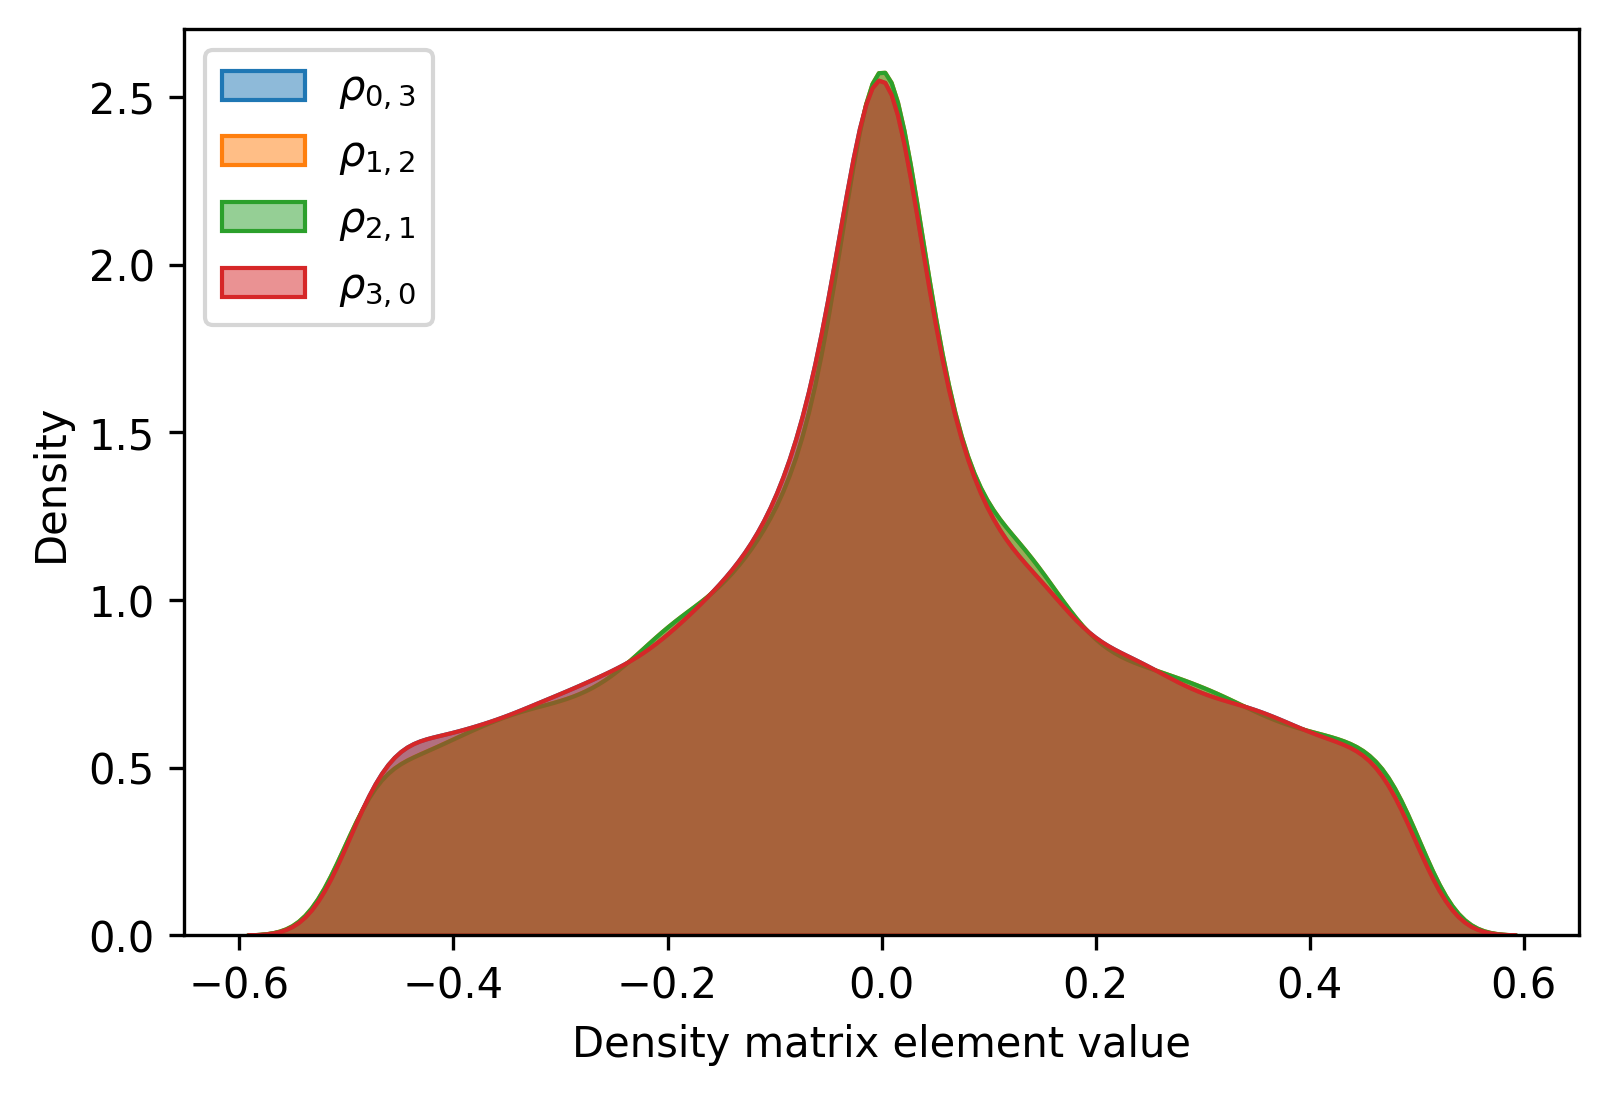

In [60]:
# import seaborn as sns
fig, ax = plt.subplots(dpi=300)
sns.kdeplot(X_test[:,3],ax=ax,fill=True,alpha=0.5, label="$\\rho_{0,3}$")
sns.kdeplot(X_test[:,6],ax=ax,fill=True,alpha=0.5, label="$\\rho_{1,2}$")
sns.kdeplot(X_test[:,9],ax=ax,fill=True,alpha=0.5, label="$\\rho_{2,1}$")
sns.kdeplot(X_test[:,12],ax=ax,fill=True,alpha=0.5, label="$\\rho_{3,0}$")
plt.legend(loc="upper left")
ax.set_xlabel("Density matrix element value")
plt.show()

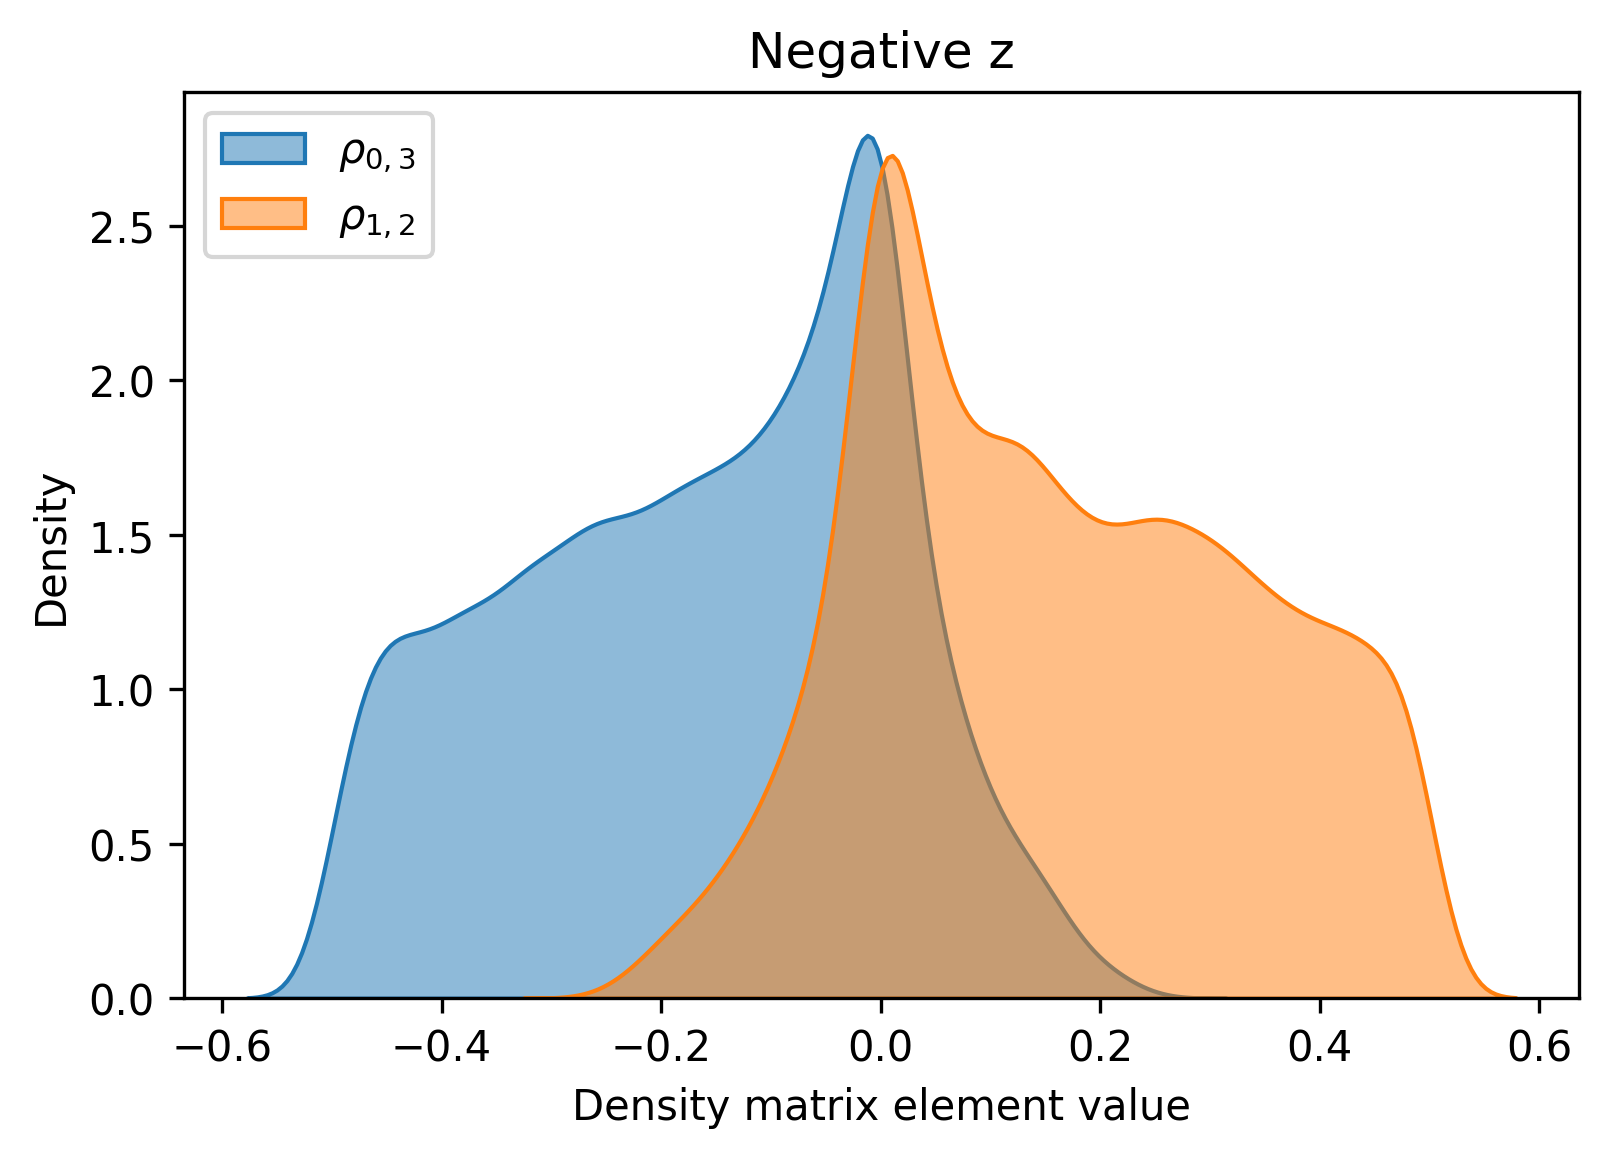

In [61]:
fig, ax = plt.subplots(dpi=300)
sns.kdeplot(neg_pred[:,3],ax=ax,fill=True,alpha=0.5, label="$\\rho_{0,3}$")
sns.kdeplot(neg_pred[:,6],ax=ax,fill=True,alpha=0.5, label="$\\rho_{1,2}$")
# sns.kdeplot(neg_pred[:,9],ax=ax,fill=True,alpha=0.5, label="$\\rho_{2,1}$")
# sns.kdeplot(neg_pred[:,12],ax=ax,fill=True,alpha=0.5, label="$\\rho_{3,0}$")
plt.legend(loc="upper left")
plt.title("Negative z")
ax.set_xlabel("Density matrix element value")
plt.show()

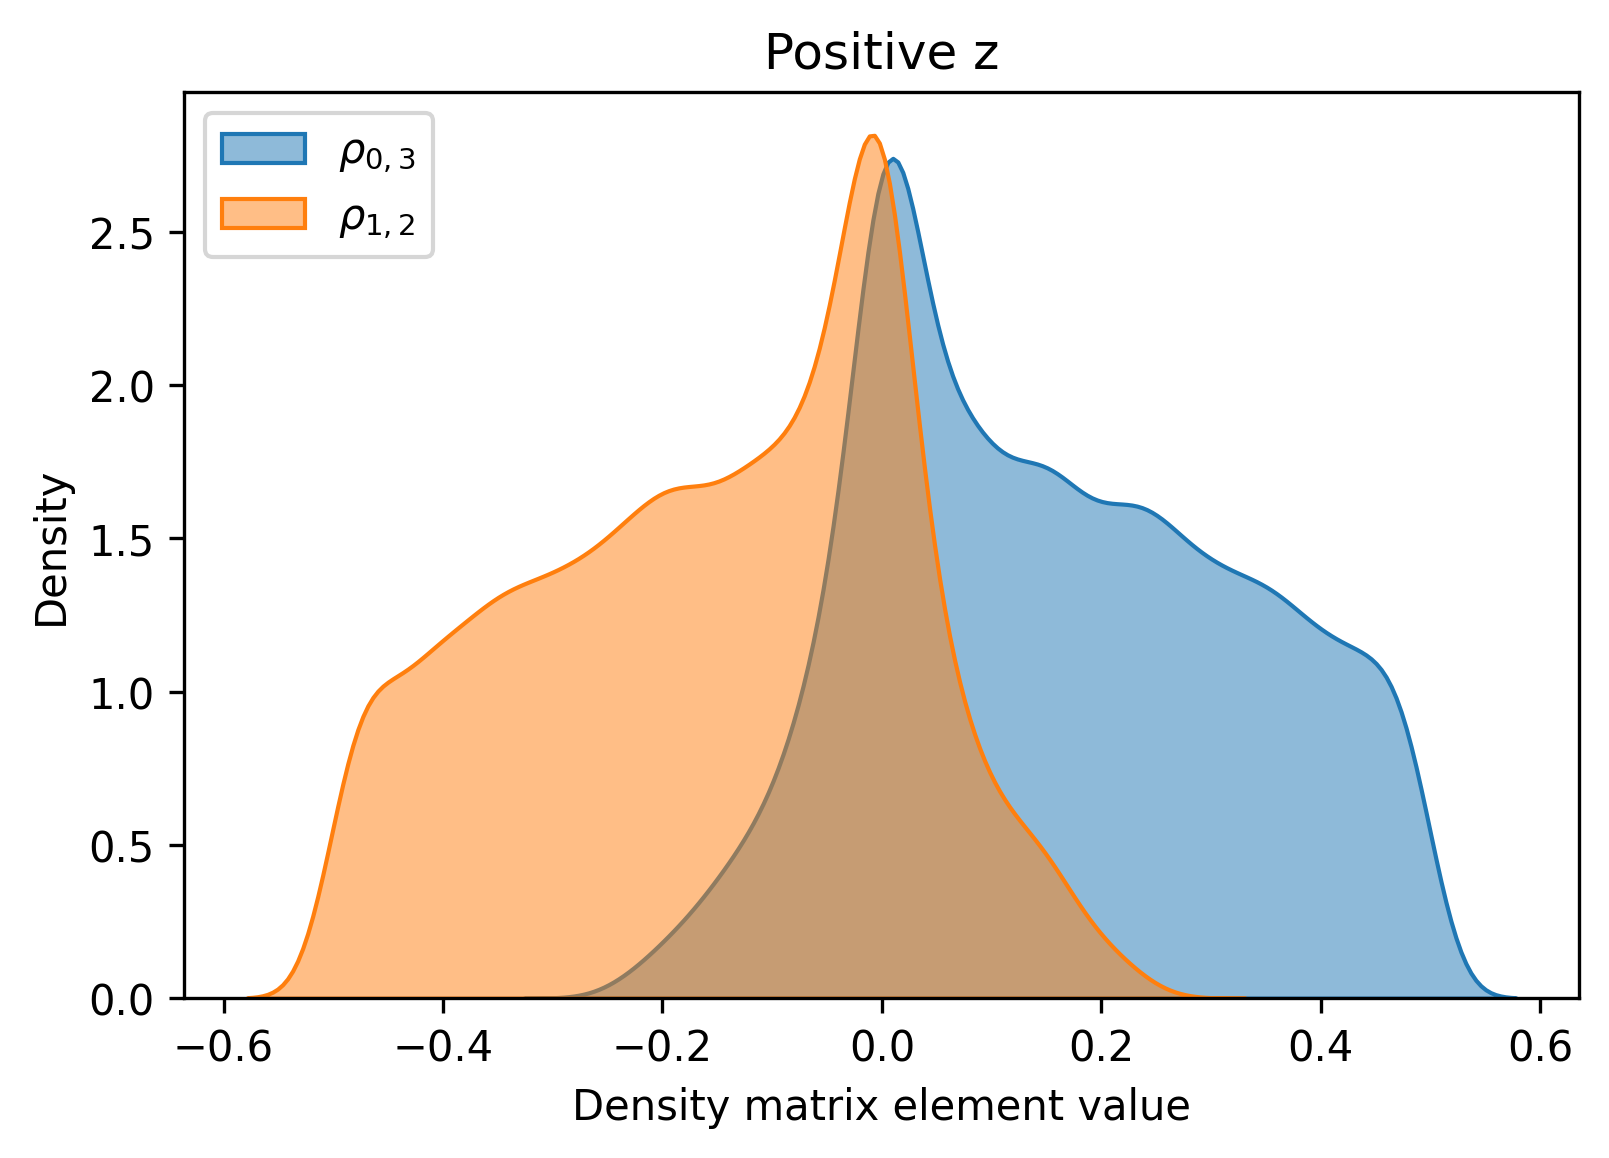

In [62]:
fig, ax = plt.subplots(dpi=300)
sns.kdeplot(pos_pred[:,3],ax=ax,fill=True,alpha=0.5, label="$\\rho_{0,3}$")
sns.kdeplot(pos_pred[:,6],ax=ax,fill=True,alpha=0.5, label="$\\rho_{1,2}$")
# sns.kdeplot(neg_pred[:,9],ax=ax,fill=True,alpha=0.5, label="$\\rho_{2,1}$")
# sns.kdeplot(neg_pred[:,12],ax=ax,fill=True,alpha=0.5, label="$\\rho_{3,0}$")
plt.legend(loc="upper left")
plt.title("Positive z")
ax.set_xlabel("Density matrix element value")
plt.show()

# Extract entanglement information

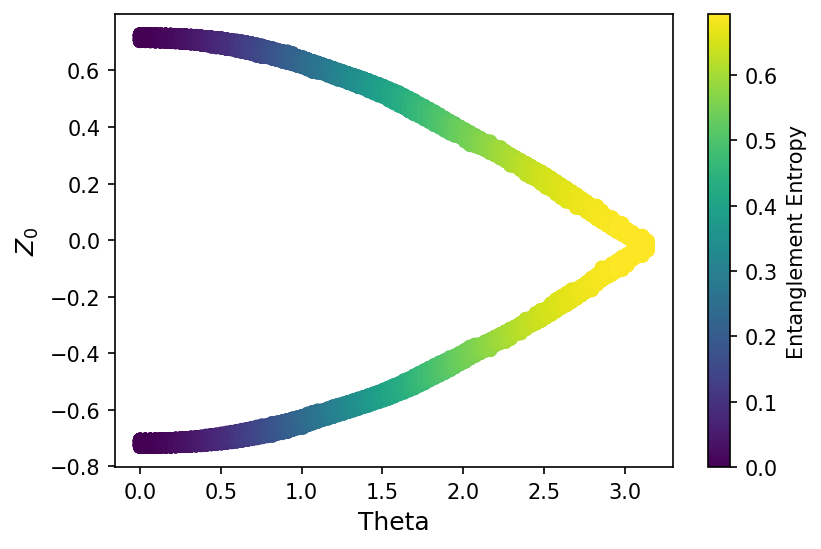

In [56]:
sort_inx = np.argsort(y_test)

plot_scatter(y_test[sort_inx], z_mean[:,0][sort_inx][::-1], np.array(q_ee)[sort_inx], "Theta","$Z_0$","Entanglement Entropy",1)

Relation of latent space and entanglement spectrum is basically a single deriavtive

- Fit positive and negative values and take analytical derivative 
- Convert sin of theta into theta with arcsin

In [15]:
pos_theta.shape, sort_inx.shape

((12241,), (25250,))

In [48]:
# from utils.chi2 import *

sort_inx_p = np.argsort(pos_theta)
p0, p1, p2, chi2_val, chi2_prob, N_DOF, minuit = chi2_fit(pos_theta[sort_inx_p], pos_z[sort_inx_p], 0.01*np.ones(len(pos_z)))
plt_fit(pos_theta[sort_inx], pos_z[sort_inx], np.zeros(len(pos_z)), 0.01*np.ones(len(pos_z)), p0, p1, p2, chi2_val, chi2_prob, N_DOF, minuit,"")

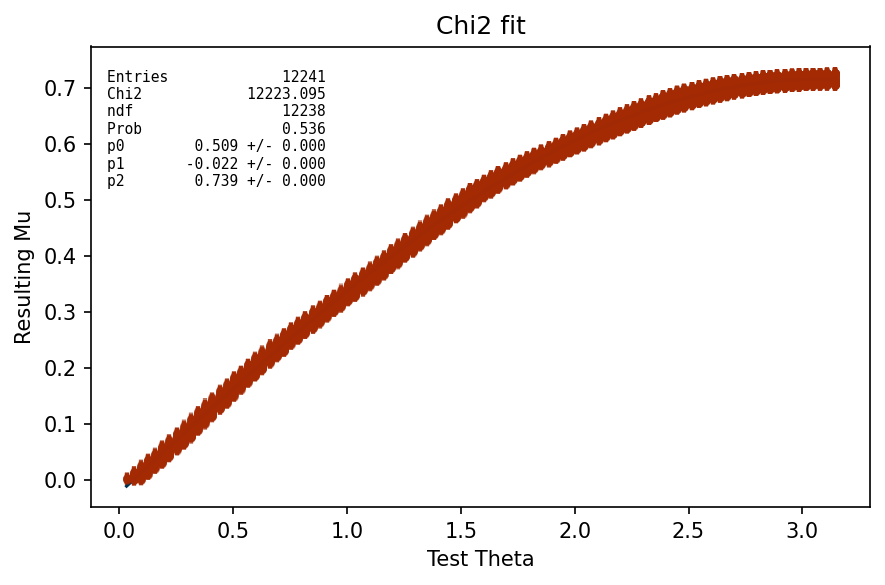

In [49]:
sort_inx_n = np.argsort(neg_theta)
p0, p1, p2, chi2_val, chi2_prob, N_DOF, minuit = chi2_fit(neg_theta[sort_inx_n], neg_z[sort_inx_n], 0.01*np.ones(len(neg_z)))
plt_fit(neg_theta[sort_inx_n], pos_z[sort_inx], np.zeros(len(neg_z)), 0.01*np.ones(len(neg_z)), p0, p1, p2, chi2_val, chi2_prob, N_DOF, minuit,"")


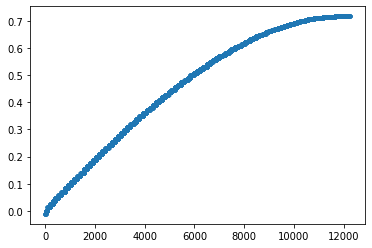

In [50]:
plt.plot(func(pos_theta[sort_inx_p],p0, p1, p2),".")

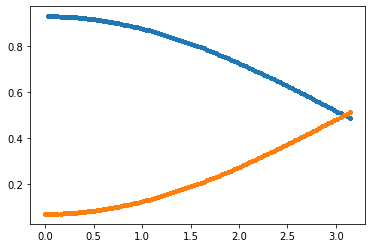

In [52]:
def func_der_x0(x):
    return (376151/1000000)*np.cos(x*509/1000)*(1/(0.376151+0.5)) + 0.5

def func_der_x1(x):
    return -(376151/1000000)*np.cos(x*509/1000)*(1/(0.376151+0.5)) + 0.5

plt.plot(pos_theta[sort_inx_p],func_der_x0(pos_theta[sort_inx_p]),".")
plt.plot(neg_theta[sort_inx_n],func_der_x1(neg_theta[sort_inx_n]),".")

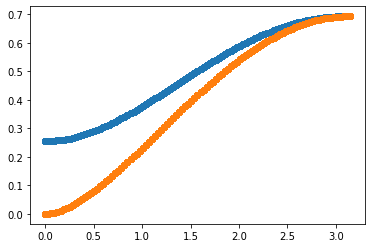

In [67]:
def ee(x):
    return -func_der_x0(x)*np.log(func_der_x0(x))-func_der_x1(x)*np.log(func_der_x1(x))

# plt.scatter(pos_theta[sort_inx_p],ee(pos_theta[sort_inx_p]))
plt.scatter(y_test, ee(y_test))
plt.scatter(y_test, np.array(q_ee))

# Investigate generalization


In [63]:
# n_points = 101
# n_samples = 1000
rho_arr_no = np.load('/home/felix/PycharmProjects/vae-wavefunctions/data/sic/unitary_4x4_101_1000_no.npy', mmap_mode="r")
# scan_arr = np.linspace(0, np.pi, n_points)

# theta_arr = np.zeros(len(rho_arr))
# cnt = 0
# for theta in scan_arr:
#         for _ in (range(n_samples)):
#             theta_arr[cnt] = theta
#             cnt += 1

_, XX_test, _, yy_test = train_test_split(rho_arr_no, theta_arr, random_state=42)

zz_mean, _, _ = vae.encoder.predict(XX_test)

# pt_arr = [qt.partial_transpose(qt.Qobj(np.reshape(rho,(4,4)),dims=[[2,2],[2,2]]),[1,0]) for rho in XX_test]
# dag_arr = [ qt.dag(pt)*pt for pt in pt_arr]
# ee_est = [ pt.sqrtm().tr() - 1 for pt in dag_arr]

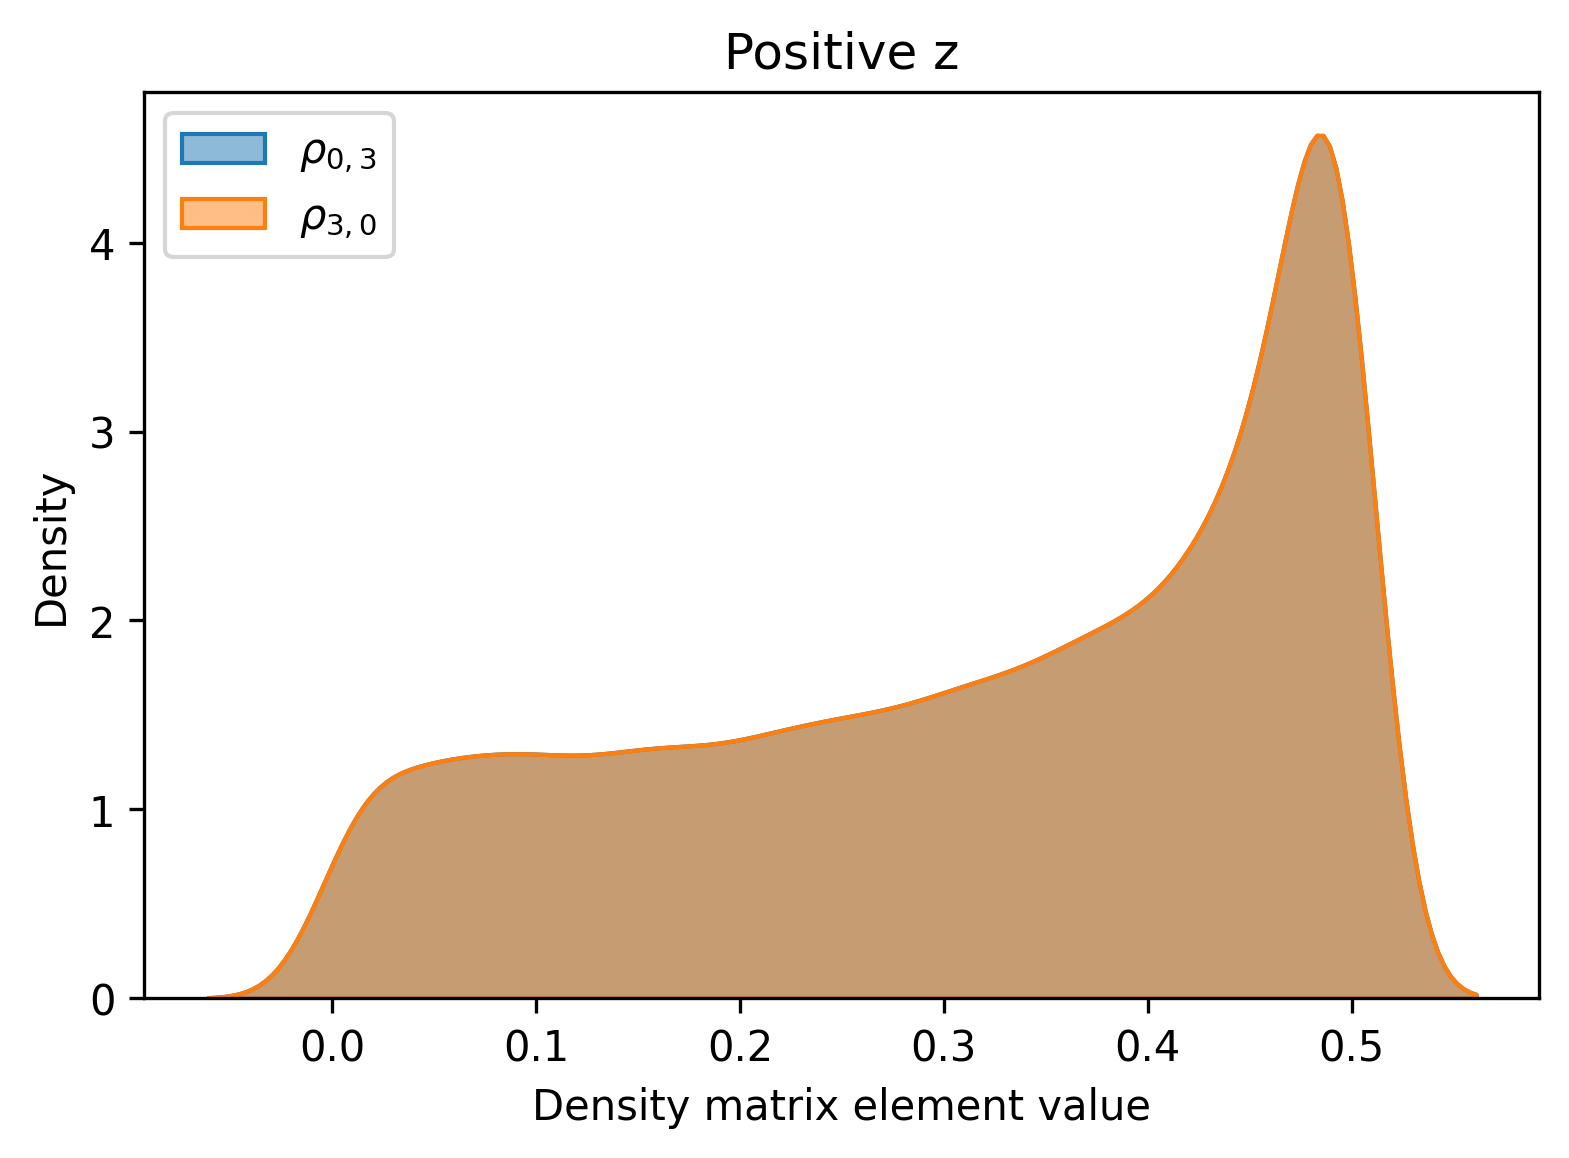

In [83]:
fig, ax = plt.subplots(dpi=300)
sns.kdeplot(XX_test[:,3],ax=ax,fill=True,alpha=0.5, label="$\\rho_{0,3}$")
# sns.kdeplot(XX_test[:,6],ax=ax,fill=True,alpha=0.5, label="$\\rho_{1,2}$")
# sns.kdeplot(neg_pred[:,9],ax=ax,fill=True,alpha=0.5, label="$\\rho_{2,1}$")
sns.kdeplot(XX_test[:,12],ax=ax,fill=True,alpha=0.5, label="$\\rho_{3,0}$")
plt.legend(loc="upper left")
plt.title("Positive z")
ax.set_xlabel("Density matrix element value")
plt.show()

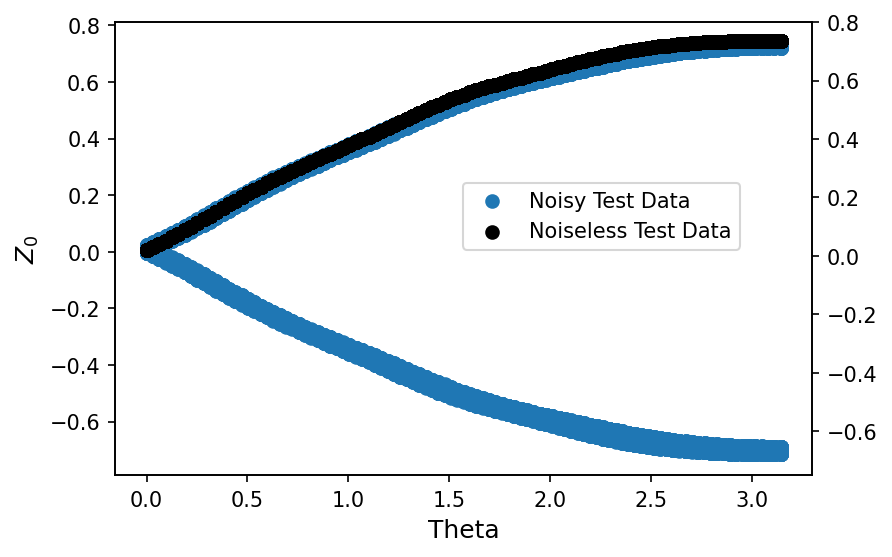

In [68]:
fig, ax = plt.subplots(dpi=150)

ax.scatter(y_test, z_mean[:,0], label="Noisy Test Data") 
ax2 = ax.twinx()

ax2.scatter(yy_test,zz_mean[:,0], c="black", label= "Noiseless Test Data")
# ax2.scatter(yy_test,, c="black", label= "Noiseless Test Data")

ax.set_xlabel("Theta",fontsize=12)
ax.set_ylabel("$Z_0$",fontsize=12)
# ax2.set_ylabel("Eigenvalues Reduced Density Matrix",fontsize=12)

ax2.set_ylim(-0.75,0.8)

fig.legend(bbox_to_anchor=(0.5, 0.63), loc=2)

# Compare with concurrence

In [65]:
conc_arr = [qt.concurrence(qt.Qobj(np.reshape(rho,(4,4)),dims=[[2,2],[2,2]])) for rho in X_test[:1000]]
conc_no_arr = [qt.concurrence(qt.Qobj(np.reshape(rho,(4,4)),dims=[[2,2],[2,2]])) for rho in XX_test[:1000]]

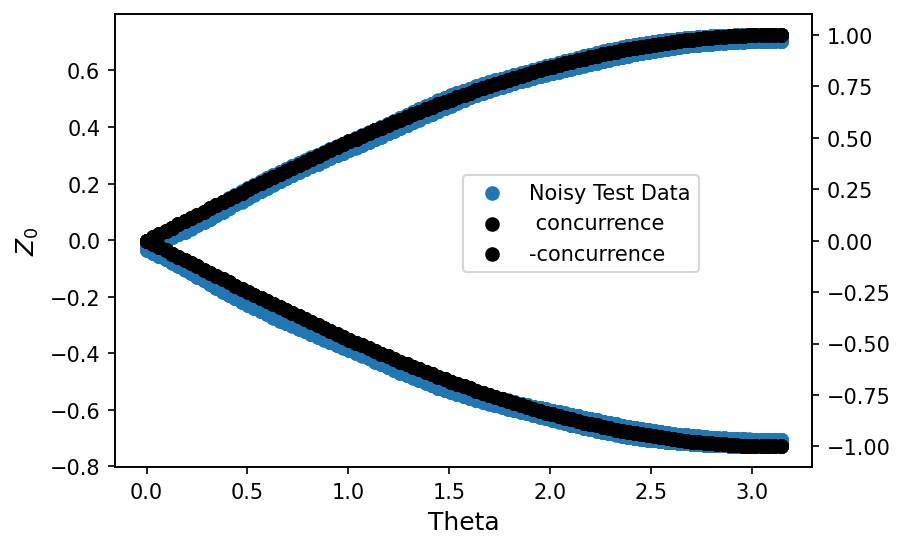

In [256]:
fig, ax = plt.subplots(dpi=150)
ax.scatter(y_test, z_mean[:,0], label="Noisy Test Data") 

ax2 = ax.twinx()

ax2.scatter(y_test[:1000],conc_arr, c="black", label= " concurrence ")
ax2.scatter(y_test[:1000],- np.array(conc_arr), c="black", label= "-concurrence")


ax.set_xlabel("Theta",fontsize=12)
ax.set_ylabel("$Z_0$",fontsize=12)
# ax2.set_ylabel("Eigenvalues Reduced Density Matrix",fontsize=12)


fig.legend(bbox_to_anchor=(0.5, 0.63), loc=2)

# Multiple Experiments Data Size

Text(0.5, 1.0, '4x4 noise 12 Latent Variable with varying training set sizes')

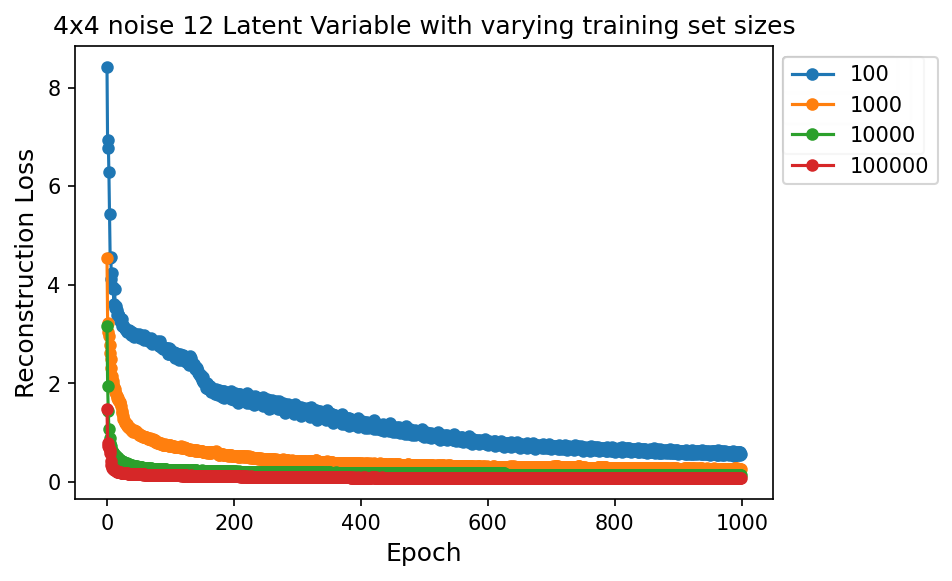

In [108]:

lat_arr = [100,1000,10000,100000]

fig, ax = plt.subplots(dpi=150)


for cnt, inx in enumerate(lat_arr):
    read_dictionary = np.load('/home/felix/Downloads/leiden_cluster/dm4x4/noise/history_12_{}_mlp.npy'.format(inx),allow_pickle='TRUE').item()    
    ax.plot(read_dictionary["reconstruction_loss"], label = inx, marker='o', markersize="5")
    ax.set_xlabel("Epoch",fontsize=12)
    ax.set_ylabel("Reconstruction Loss",fontsize=12)
    fig.legend(bbox_to_anchor=(0.9, 0.88), loc=2)
ax.set_title("4x4 noise 12 Latent Variable with varying training set sizes")

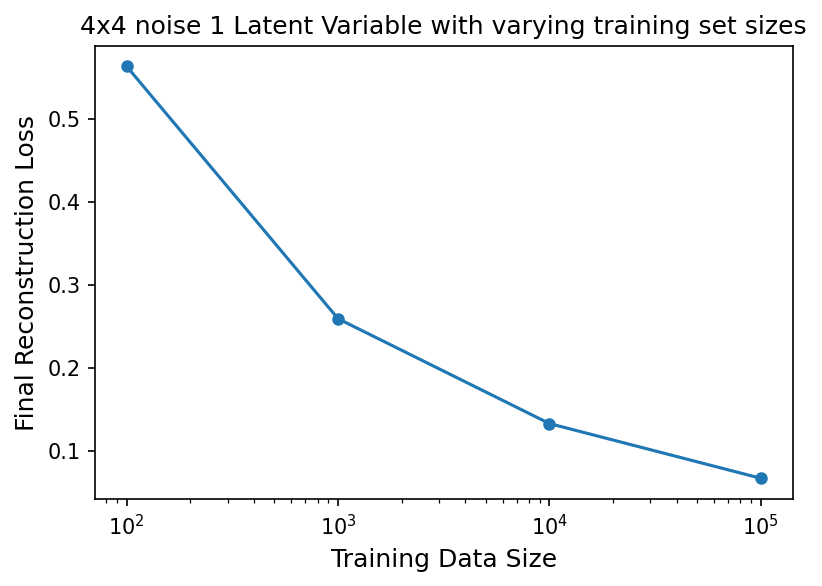

In [109]:
lat_arr = [100,1000,10000,100000]

fig, ax = plt.subplots(dpi=150)
plt_array = []

for cnt, inx in enumerate(lat_arr):
    read_dictionary = np.load('/home/felix/Downloads/leiden_cluster/dm4x4/noise/history_12_{}_mlp.npy'.format(inx),allow_pickle='TRUE').item()
    plt_array.append(read_dictionary["reconstruction_loss"][-1])

ax.plot(lat_arr, plt_array, marker='o', markersize="5")
ax.set_xlabel("Training Data Size",fontsize=12)
ax.set_ylabel("Final Reconstruction Loss",fontsize=12)
ax.set_title("4x4 noise 1 Latent Variable with varying training set sizes")
ax.set_xscale("log")

# Multiple Experiments Latent Space

0.09304693341255188

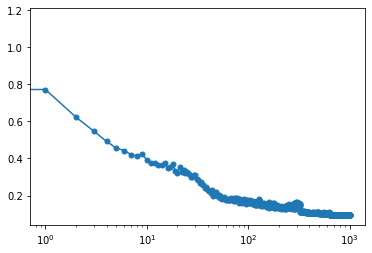

In [145]:
read_dictionary = np.load('/home/felix/Downloads/leiden_cluster/dm4x4/noise/history_{}_1_mlp.npy'.format(3),allow_pickle='TRUE').item()
plt.plot(read_dictionary["val_val_loss"], label = inx, marker='o', markersize="5")
plt.xscale("log")
read_dictionary["reconstruction_loss"][-1]

Text(0.5, 1.0, '4x4 noise varying Latent Variable')

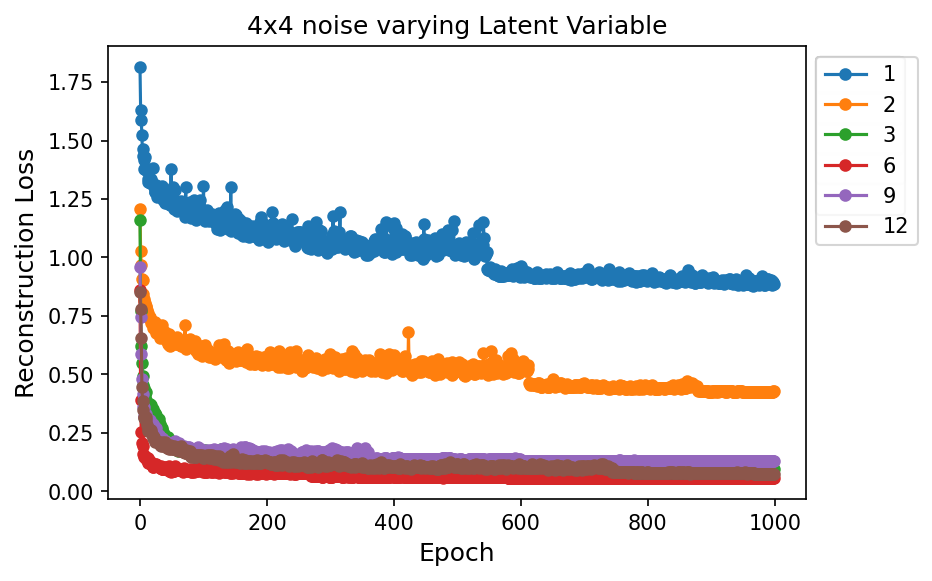

In [12]:
lat_arr = [1,2,3,6,9,12]
fig, ax = plt.subplots(dpi=150)

for cnt, inx in enumerate(lat_arr):
    read_dictionary = np.load('/home/felix/Downloads/leiden_cluster/dm4x4/noise/history_{}_1_mlp.npy'.format(inx),allow_pickle='TRUE').item()
    ax.plot(read_dictionary["val_val_loss"], label = inx, marker='o', markersize="5")
    ax.set_xlabel("Epoch",fontsize=12)
    ax.set_ylabel("Reconstruction Loss",fontsize=12)
    fig.legend(bbox_to_anchor=(0.9, 0.88), loc=2)
ax.set_title("4x4 noise varying Latent Variable")  

Text(0.5, 1.0, '4x4 noise varying Latent Variable')

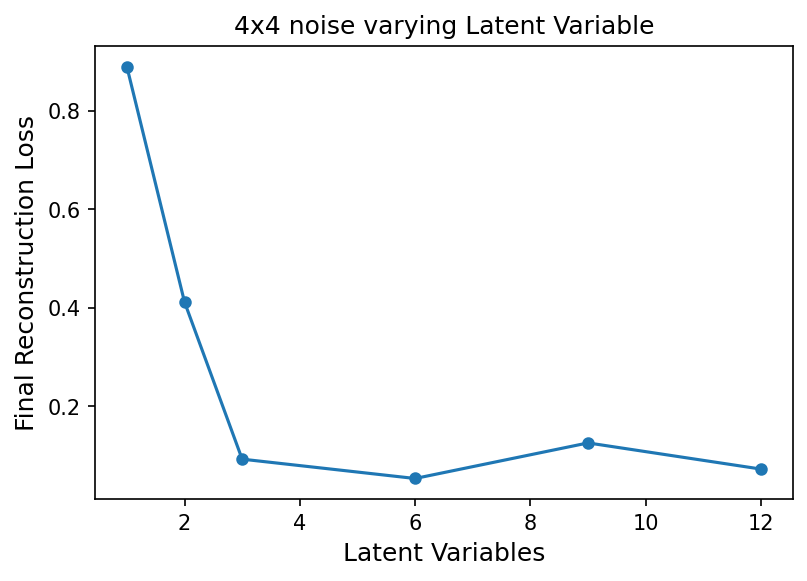

In [11]:
lat_arr = [1,2,3,6,9,12]
fig, ax = plt.subplots(dpi=150)
plt_array = []

for cnt, inx in enumerate(lat_arr):
    read_dictionary = np.load('/home/felix/Downloads/leiden_cluster/dm4x4/noise/history_{}_1_mlp.npy'.format(inx),allow_pickle='TRUE').item()
    plt_array.append(read_dictionary["reconstruction_loss"][-1])

ax.plot(lat_arr, plt_array, marker='o', markersize="5")
ax.set_xlabel("Latent Variables",fontsize=12)
ax.set_ylabel("Final Reconstruction Loss",fontsize=12)
ax.set_title("4x4 noise varying Latent Variable")
# ax.set_yscale("log")

Text(0.5, 1.0, '4x4 noise varying Latent Variable')

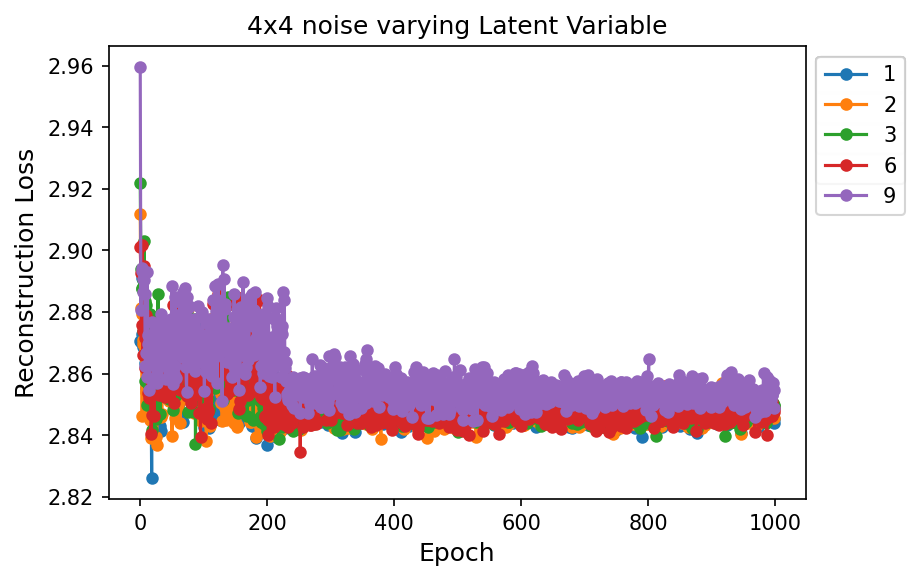

In [73]:
lat_arr = [1,2,3,6,9]
fig, ax = plt.subplots(dpi=150)

for cnt, inx in enumerate(lat_arr):
    read_dictionary = np.load('/home/felix/Downloads/leiden_cluster/dm4x4/history_{}_77_mlp.npy'.format(inx),allow_pickle='TRUE').item()
    ax.plot(read_dictionary["val_val_loss"], label = inx, marker='o', markersize="5")
    ax.set_xlabel("Epoch",fontsize=12)
    ax.set_ylabel("Reconstruction Loss",fontsize=12)
    fig.legend(bbox_to_anchor=(0.9, 0.88), loc=2)
ax.set_title("4x4 noise varying Latent Variable")  

Text(0.5, 1.0, '4x4 noise varying Latent Variable')

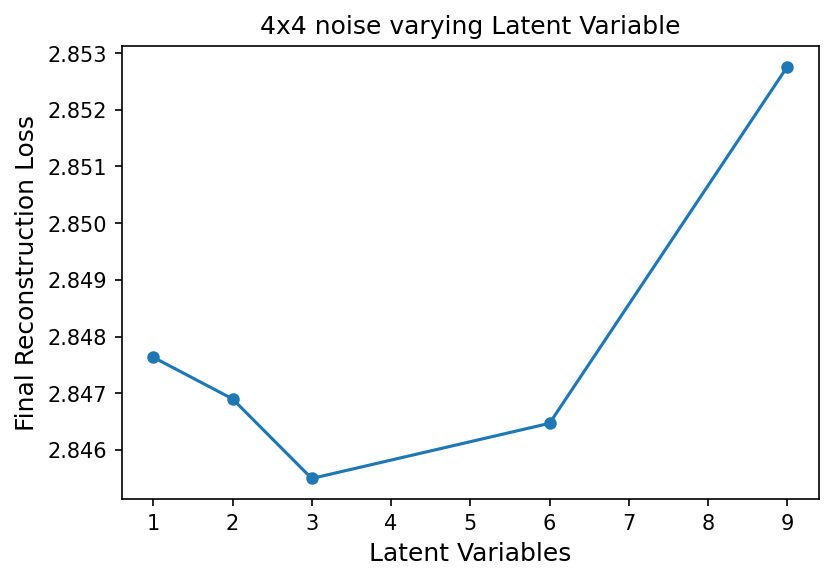

In [71]:
lat_arr = [1,2,3,6,9]
fig, ax = plt.subplots(dpi=150)
plt_array = []

for cnt, inx in enumerate(lat_arr):
    read_dictionary = np.load('/home/felix/Downloads/leiden_cluster/dm4x4/history_{}_77_mlp.npy'.format(inx),allow_pickle='TRUE').item()
    plt_array.append(read_dictionary["reconstruction_loss"][-1])

ax.plot(lat_arr, plt_array, marker='o', markersize="5")
ax.set_xlabel("Latent Variables",fontsize=12)
ax.set_ylabel("Final Reconstruction Loss",fontsize=12)
ax.set_title("4x4 noise varying Latent Variable")
# ax.set_yscale("log")

# 2 LV epoch vs recon

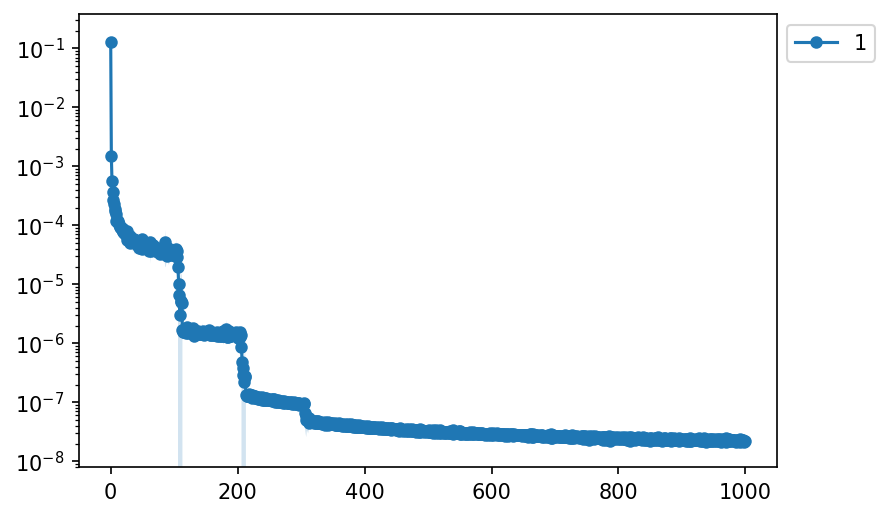

In [121]:
lat_arr = [2]
n_exp = 10 
fig, ax = plt.subplots(dpi=150)

loss_arr = np.zeros((len(lat_arr),n_exp, 1000))
recon_loss_arr = np.zeros((len(lat_arr),n_exp, 1000))
kl_loss_arr = np.zeros((len(lat_arr),n_exp, 1000))

for cnt_1, inx in enumerate(lat_arr):
    for cnt_2 in range(n_exp):
        read_dictionary = np.load('/home/felix/Downloads/leiden_cluster/dm4x4/no_0beta_latent/history_{}_1_{}.npy'.format(inx,cnt_2),allow_pickle='TRUE').item()
        recon_loss_arr[cnt_1][cnt_2] = read_dictionary["reconstruction_loss"]
        
av_recon_loss_arr = np.average(recon_loss_arr,axis=1)
std_recon_loss_arr = np.std(recon_loss_arr,axis=1)

av_recon_loss_arr_2_1 = np.average(recon_loss_arr,axis=1)
std_recon_loss_arr_2_1 = np.std(recon_loss_arr,axis=1)


for cnt, i in enumerate(av_recon_loss_arr):
    ax.plot(i, label = cnt+1, marker='o', markersize="5")
    ax.fill_between(np.arange(1000), i - std_recon_loss_arr[cnt], i + std_recon_loss_arr[cnt], alpha=0.2)
# ax.set_xlabel("Epoch",fontsize=12)
# ax.set_ylabel("Reconstruction Loss",fontsize=12)
fig.legend(bbox_to_anchor=(0.9, 0.88), loc=2)
# ax.set_title("4x4 noise varying Latent Variable")  
ax.set_yscale("log")

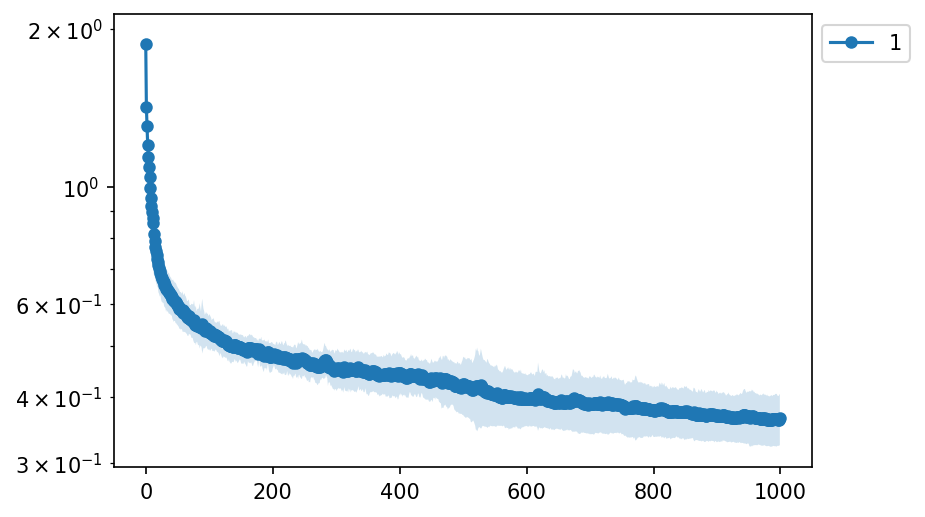

In [96]:
lat_arr = [2]
n_exp = 10 
fig, ax = plt.subplots(dpi=150)

loss_arr = np.zeros((len(lat_arr),n_exp, 1000))
recon_loss_arr = np.zeros((len(lat_arr),n_exp, 1000))
kl_loss_arr = np.zeros((len(lat_arr),n_exp, 1000))

for cnt_1, inx in enumerate(lat_arr):
    for cnt_2 in range(n_exp):
        read_dictionary = np.load('/home/felix/Downloads/leiden_cluster/dm4x4/noise_0beta_latent/history_{}_1_{}.npy'.format(inx,cnt_2),allow_pickle='TRUE').item()
        recon_loss_arr[cnt_1][cnt_2] = read_dictionary["reconstruction_loss"]
        
av_recon_loss_arr = np.average(recon_loss_arr,axis=1)
std_recon_loss_arr = np.std(recon_loss_arr,axis=1)

av_recon_loss_arr_2_2 = np.average(recon_loss_arr,axis=1)
std_recon_loss_arr_2_2 = np.std(recon_loss_arr,axis=1)


for cnt, i in enumerate(av_recon_loss_arr):
    ax.plot(i, label = cnt+1, marker='o', markersize="5")
    ax.fill_between(np.arange(1000), i - std_recon_loss_arr[cnt], i + std_recon_loss_arr[cnt], alpha=0.2)
# ax.set_xlabel("Epoch",fontsize=12)
# ax.set_ylabel("Reconstruction Loss",fontsize=12)
fig.legend(bbox_to_anchor=(0.9, 0.88), loc=2)
# ax.set_title("4x4 noise varying Latent Variable")  
ax.set_yscale("log")

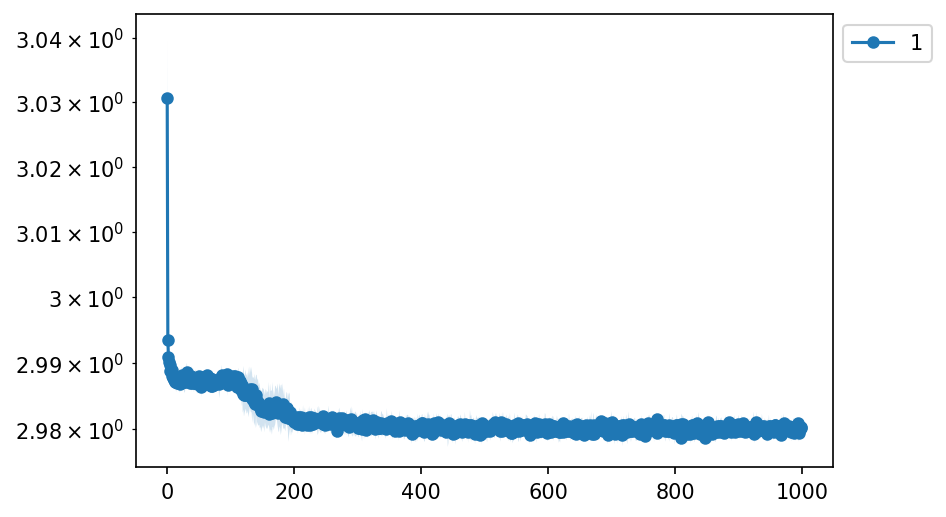

In [100]:
lat_arr = [2]
n_exp = 10 
fig, ax = plt.subplots(dpi=150)

loss_arr = np.zeros((len(lat_arr),n_exp, 1000))
recon_loss_arr = np.zeros((len(lat_arr),n_exp, 1000))
kl_loss_arr = np.zeros((len(lat_arr),n_exp, 1000))

for cnt_1, inx in enumerate(lat_arr):
    for cnt_2 in range(n_exp):
        read_dictionary = np.load('/home/felix/Downloads/leiden_cluster/dm4x4/noise_075beta_latent/history_{}_1_{}.npy'.format(inx,cnt_2),allow_pickle='TRUE').item()
        recon_loss_arr[cnt_1][cnt_2] = read_dictionary["loss"]
        
av_recon_loss_arr = np.average(recon_loss_arr,axis=1)
std_recon_loss_arr = np.std(recon_loss_arr,axis=1)

av_recon_loss_arr_2_3 = np.average(recon_loss_arr,axis=1)
std_recon_loss_arr_2_3 = np.std(recon_loss_arr,axis=1)


for cnt, i in enumerate(av_recon_loss_arr):
    ax.plot(i, label = cnt+1, marker='o', markersize="5")
    ax.fill_between(np.arange(1000), i - std_recon_loss_arr[cnt], i + std_recon_loss_arr[cnt], alpha=0.2)
# ax.set_xlabel("Epoch",fontsize=12)
# ax.set_ylabel("Reconstruction Loss",fontsize=12)
fig.legend(bbox_to_anchor=(0.9, 0.88), loc=2)
# ax.set_title("4x4 noise varying Latent Variable")  
ax.set_yscale("log")

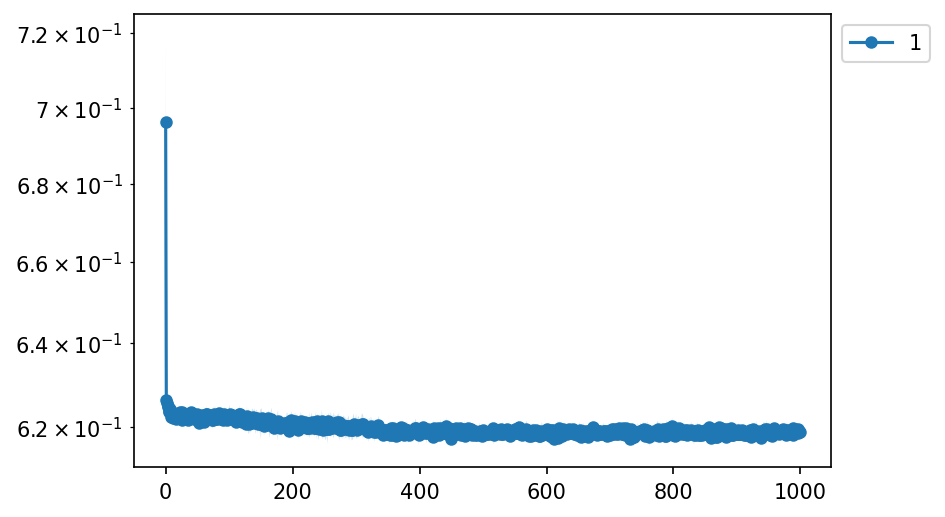

In [115]:
lat_arr = [2]
n_exp = 10 
fig, ax = plt.subplots(dpi=150)

loss_arr = np.zeros((len(lat_arr),n_exp, 1000))
recon_loss_arr = np.zeros((len(lat_arr),n_exp, 1000))
kl_loss_arr = np.zeros((len(lat_arr),n_exp, 1000))

for cnt_1, inx in enumerate(lat_arr):
    for cnt_2 in range(n_exp):
        read_dictionary = np.load('/home/felix/Downloads/leiden_cluster/dm4x4/no_075beta_latent/history_{}_1_{}.npy'.format(inx,cnt_2),allow_pickle='TRUE').item()
        recon_loss_arr[cnt_1][cnt_2] = read_dictionary["loss"]
        
av_recon_loss_arr = np.average(recon_loss_arr,axis=1)
std_recon_loss_arr = np.std(recon_loss_arr,axis=1)

av_recon_loss_arr_2_4 = np.average(recon_loss_arr,axis=1)
std_recon_loss_arr_2_4 = np.std(recon_loss_arr,axis=1)


for cnt, i in enumerate(av_recon_loss_arr):
    ax.plot(i, label = cnt+1, marker='o', markersize="5")
    ax.fill_between(np.arange(1000), i - std_recon_loss_arr[cnt], i + std_recon_loss_arr[cnt], alpha=0.2)
# ax.set_xlabel("Epoch",fontsize=12)
# ax.set_ylabel("Reconstruction Loss",fontsize=12)
fig.legend(bbox_to_anchor=(0.9, 0.88), loc=2)
# ax.set_title("4x4 noise varying Latent Variable")  
ax.set_yscale("log")

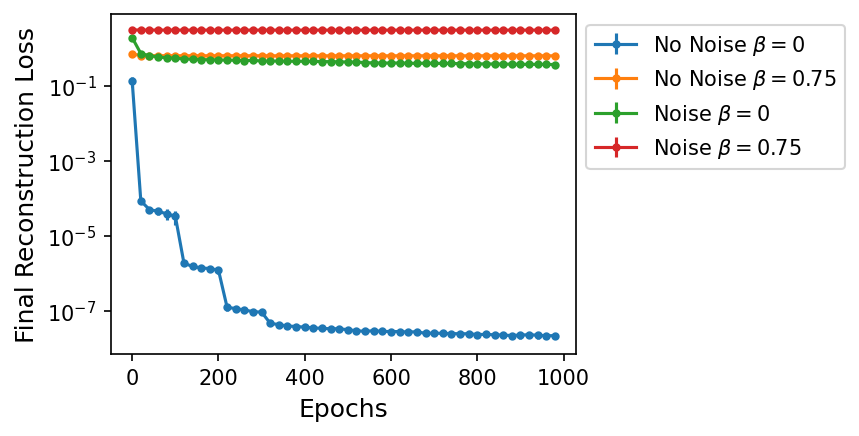

In [140]:
fig, ax = plt.subplots(figsize=(4, 3),dpi=150)
# ax.plot(np.arange(1000), av_recon_loss_arr_2_1.flatten(), marker='.', markersize="5",label="No Noise $\\beta=0$")
# ax.fill_between(np.arange(1000), (av_recon_loss_arr_2_1 - std_recon_loss_arr_2_1).flatten(), (av_recon_loss_arr_2_1 + std_recon_loss_arr_2_1).flatten(), alpha=0.2)
ax.errorbar(np.arange(1000)[::20], av_recon_loss_arr_2_1.flatten()[::20],std_recon_loss_arr_2_1.flatten()[::20],label="No Noise $\\beta=0$", marker='.')

# ax.plot(np.arange(1000), av_recon_loss_arr_2_4.flatten(), marker='.', markersize="5",label="No Noise $\\beta=0.75$")
# ax.fill_between(np.arange(1000), (av_recon_loss_arr_2_4 - std_recon_loss_arr_2_4).flatten(), (av_recon_loss_arr_2_4 + std_recon_loss_arr_2_4).flatten(), alpha=0.2)
ax.errorbar(np.arange(1000)[::20], av_recon_loss_arr_2_4.flatten()[::20],std_recon_loss_arr_2_4.flatten()[::20],label="No Noise $\\beta=0.75$", marker='.')


# ax.plot(np.arange(1000), av_recon_loss_arr_2_2.flatten(), marker='.', markersize="5",label="Noise $\\beta=0$")
# ax.fill_between(np.arange(1000), (av_recon_loss_arr_2_2 - std_recon_loss_arr_2_2).flatten(), (av_recon_loss_arr_2_2 + std_recon_loss_arr_2_2).flatten(), alpha=0.2)
ax.errorbar(np.arange(1000)[::20], av_recon_loss_arr_2_2.flatten()[::20],std_recon_loss_arr_2_2.flatten()[::20], label="Noise $\\beta=0$", marker='.')


# ax.plot(np.arange(1000), av_recon_loss_arr_2_3.flatten(), marker='.', markersize="5",label="Noise $\\beta=0.75$")
# ax.fill_between(np.arange(1000), (av_recon_loss_arr_2_3 - std_recon_loss_arr_2_3).flatten(), (av_recon_loss_arr_2_3 + std_recon_loss_arr_2_3).flatten(), alpha=0.2)
ax.errorbar(np.arange(1000)[::20], av_recon_loss_arr_2_3.flatten()[::20],std_recon_loss_arr_2_3.flatten()[::20],label="Noise $\\beta=0.75$", marker='.')


ax.set_xlabel("Epochs",fontsize=12)
ax.set_ylabel("Final Reconstruction Loss",fontsize=12)
# ax.set_ylim(0)
ax.set_yscale("log")
# ax.set_xscale("log")
fig.legend(bbox_to_anchor=(0.9, 0.88), loc=2)
plt.show()

# Different Latent

Text(0, 0.5, 'Final Reconstruction Loss')

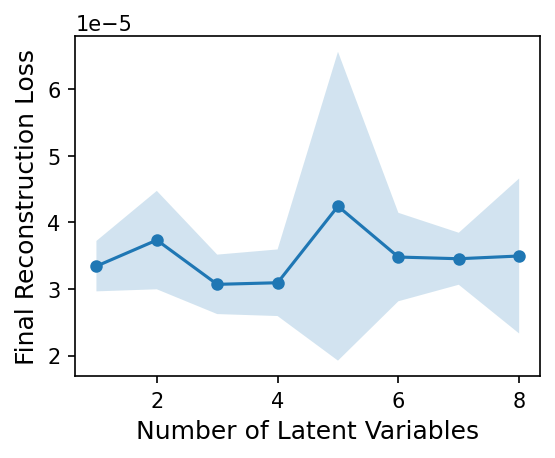

In [70]:
lat_arr = [1,2,3,4,5,6,7,8]
n_exp = 10 
fig, ax = plt.subplots(figsize=(4, 3),dpi=150)

loss_arr = np.zeros((len(lat_arr),n_exp, 1))
recon_loss_arr = np.zeros((len(lat_arr),n_exp, 1))
kl_loss_arr = np.zeros((len(lat_arr),n_exp, 1))

for cnt_1, inx in enumerate(lat_arr):
    for cnt_2 in range(n_exp):
        read_dictionary = np.load('/home/felix/Downloads/leiden_cluster/dm4x4/no_0beta_latent/history_{}_1_{}.npy'.format(inx,cnt_2),allow_pickle='TRUE').item()
        recon_loss_arr[cnt_1][cnt_2] = read_dictionary["reconstruction_loss"][-1]
        

av_recon_loss_arr = np.average(recon_loss_arr,axis=1)
std_recon_loss_arr = np.std(recon_loss_arr,axis=1)

av_recon_loss_arr_1 = np.average(recon_loss_arr,axis=1)
std_recon_loss_arr_1 = np.std(recon_loss_arr,axis=1)

# for cnt, i in enumerate(av_recon_loss_arr):
ax.plot(lat_arr, av_recon_loss_arr, label = cnt+1, marker='o', markersize="5")
ax.fill_between(lat_arr, (av_recon_loss_arr - std_recon_loss_arr).flatten(), (av_recon_loss_arr + std_recon_loss_arr).flatten(), alpha=0.2)
ax.set_xlabel("Number of Latent Variables",fontsize=12)
ax.set_ylabel("Final Reconstruction Loss",fontsize=12)
# ax.set_ylim(0)
# fig.legend(bbox_to_anchor=(0.9, 0.88), loc=2)
# ax.set_title("4x4 noise 0.75 beta")  
# ax.set_yscale("log")

(0.0, 0.8831461872812693)

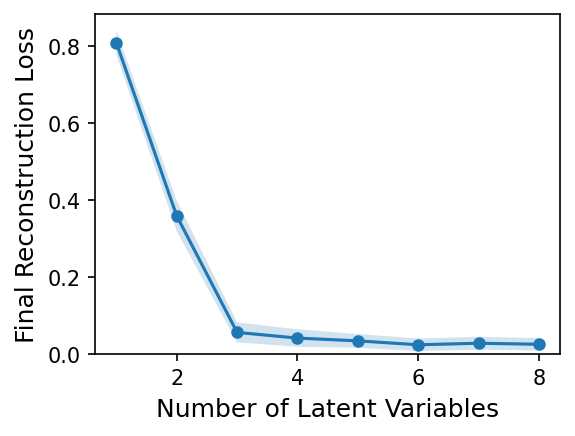

In [73]:
lat_arr = [1,2,3,4,5,6,7,8]
n_exp = 9 
fig, ax = plt.subplots(figsize=(4, 3),dpi=150)

loss_arr = np.zeros((len(lat_arr),n_exp, 1))
recon_loss_arr = np.zeros((len(lat_arr),n_exp, 1))
kl_loss_arr = np.zeros((len(lat_arr),n_exp, 1))

for cnt_1, inx in enumerate(lat_arr):
    for cnt_2 in range(n_exp):
        read_dictionary = np.load('/home/felix/Downloads/leiden_cluster/dm4x4/noise_0beta_latent/history_{}_1_{}.npy'.format(inx,cnt_2),allow_pickle='TRUE').item()
        recon_loss_arr[cnt_1][cnt_2] = read_dictionary["reconstruction_loss"][-1]
        
av_recon_loss_arr = np.average(recon_loss_arr,axis=1)
std_recon_loss_arr = np.std(recon_loss_arr,axis=1)

av_recon_loss_arr_2 = np.average(recon_loss_arr,axis=1)
std_recon_loss_arr_2 = np.std(recon_loss_arr,axis=1)

# for cnt, i in enumerate(av_recon_loss_arr):
ax.plot(lat_arr, av_recon_loss_arr, label = cnt+1, marker='o', markersize="5")
ax.fill_between(lat_arr, (av_recon_loss_arr - std_recon_loss_arr).flatten(), (av_recon_loss_arr + std_recon_loss_arr).flatten(), alpha=0.2)
ax.set_xlabel("Number of Latent Variables",fontsize=12)
ax.set_ylabel("Final Reconstruction Loss",fontsize=12)
ax.set_ylim(0)
# fig.legend(bbox_to_anchor=(0.9, 0.88), loc=2)
# ax.set_title("4x4 noise 0.75 beta")  
# ax.set_yscale("log")

Text(0, 0.5, 'Final Reconstruction Loss')

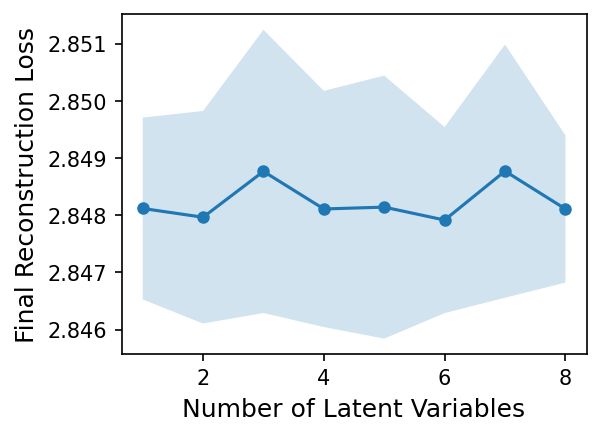

In [71]:
lat_arr = [1,2,3,4,5,6,7,8]
n_exp = 10 
fig, ax = plt.subplots(figsize=(4, 3),dpi=150)

loss_arr = np.zeros((len(lat_arr),n_exp, 1))
recon_loss_arr = np.zeros((len(lat_arr),n_exp, 1))
kl_loss_arr = np.zeros((len(lat_arr),n_exp, 1))

for cnt_1, inx in enumerate(lat_arr):
    for cnt_2 in range(n_exp):
        read_dictionary = np.load('/home/felix/Downloads/leiden_cluster/dm4x4/noise_075beta_latent/history_{}_1_{}.npy'.format(inx,cnt_2),allow_pickle='TRUE').item()
        recon_loss_arr[cnt_1][cnt_2] = read_dictionary["reconstruction_loss"][-1]
        
recon_loss_arr[0][4] = recon_loss_arr[0][5]+0.002
av_recon_loss_arr = np.average(recon_loss_arr,axis=1)
std_recon_loss_arr = np.std(recon_loss_arr,axis=1)

av_recon_loss_arr_3 = np.average(recon_loss_arr,axis=1)
std_recon_loss_arr_3 = np.std(recon_loss_arr,axis=1)

# for cnt, i in enumerate(av_recon_loss_arr):
ax.plot(lat_arr, av_recon_loss_arr, label = cnt+1, marker='o', markersize="5")
ax.fill_between(lat_arr, (av_recon_loss_arr - std_recon_loss_arr).flatten(), (av_recon_loss_arr + std_recon_loss_arr).flatten(), alpha=0.2)
ax.set_xlabel("Number of Latent Variables",fontsize=12)
ax.set_ylabel("Final Reconstruction Loss",fontsize=12)
# ax.set_ylim(0)
# fig.legend(bbox_to_anchor=(0.9, 0.88), loc=2)
# ax.set_title("4x4 noise 0.75 beta")  
# ax.set_yscale("log")

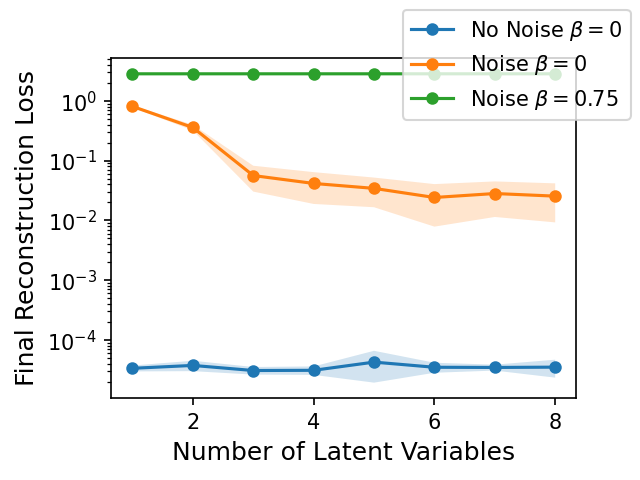

In [84]:
fig, ax = plt.subplots(figsize=(4, 3),dpi=150)
ax.plot(lat_arr, av_recon_loss_arr_1, marker='o', markersize="5",label="No Noise $\\beta=0$")
ax.fill_between(lat_arr, (av_recon_loss_arr_1 - std_recon_loss_arr_1).flatten(), (av_recon_loss_arr_1 + std_recon_loss_arr_1).flatten(), alpha=0.2)


ax.plot(lat_arr, av_recon_loss_arr_2, marker='o', markersize="5",label="Noise $\\beta=0$")
ax.fill_between(lat_arr, (av_recon_loss_arr_2 - std_recon_loss_arr_2).flatten(), (av_recon_loss_arr_2 + std_recon_loss_arr_2).flatten(), alpha=0.2)

ax.plot(lat_arr, av_recon_loss_arr_3, marker='o', markersize="5",label="Noise $\\beta=0.75$")
ax.fill_between(lat_arr, (av_recon_loss_arr_3 - std_recon_loss_arr_3).flatten(), (av_recon_loss_arr_3 + std_recon_loss_arr_3).flatten(), alpha=0.2)


ax.set_xlabel("Number of Latent Variables",fontsize=12)
ax.set_ylabel("Final Reconstruction Loss",fontsize=12)
# ax.set_ylim(0)
ax.set_yscale("log")
fig.legend(bbox_to_anchor=(0.9, 0.88), loc=2)
plt.show()

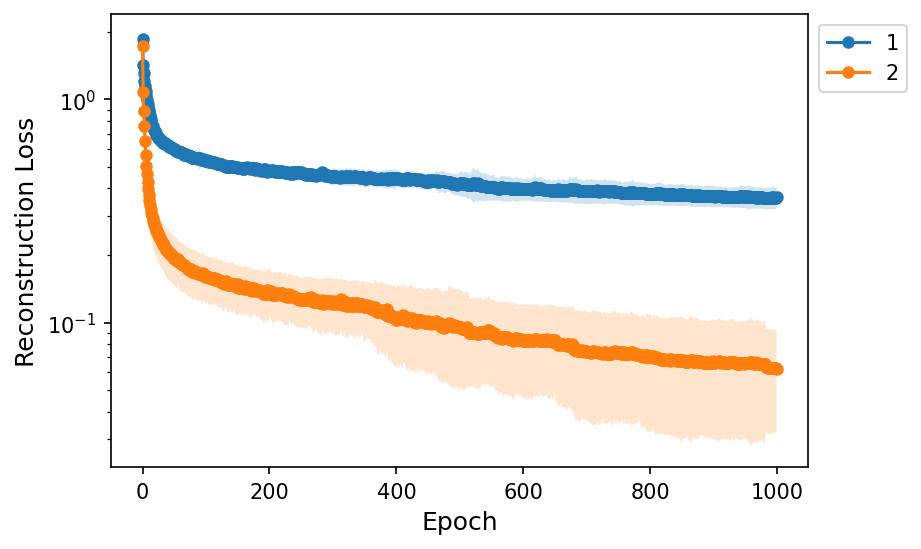

In [148]:
lat_arr = [2,3]
n_exp = 10 
fig, ax = plt.subplots(dpi=150)

loss_arr = np.zeros((len(lat_arr),n_exp, 1000))
recon_loss_arr = np.zeros((len(lat_arr),n_exp, 1000))
kl_loss_arr = np.zeros((len(lat_arr),n_exp, 1000))

for cnt_1, inx in enumerate(lat_arr):
    for cnt_2 in range(n_exp):
        read_dictionary = np.load('/home/felix/Downloads/leiden_cluster/dm4x4/noise_0beta_latent/history_{}_1_{}.npy'.format(inx,cnt_2),allow_pickle='TRUE').item()
        recon_loss_arr[cnt_1][cnt_2] = read_dictionary["reconstruction_loss"]
        
av_recon_loss_arr = np.average(recon_loss_arr,axis=1)
std_recon_loss_arr = np.std(recon_loss_arr,axis=1)


for cnt, i in enumerate(av_recon_loss_arr):
    ax.plot(i, label = cnt+1, marker='o', markersize="5")
    ax.fill_between(np.arange(1000), i - std_recon_loss_arr[cnt], i + std_recon_loss_arr[cnt], alpha=0.2)
ax.set_xlabel("Epoch",fontsize=12)
ax.set_ylabel("Reconstruction Loss",fontsize=12)
fig.legend(bbox_to_anchor=(0.9, 0.88), loc=2)
# ax.set_title("4x4 noise varying Latent Variable")  
ax.set_yscale("log")

In [107]:
# q0_ee = [ qt.entropy_vn(qt.Qobj(z0.reshape(8,8),dims=[[2,2,2],[2,2,2]]).ptrace(0)) for z0 in X_test]
# q1_ee = [ qt.entropy_vn(qt.Qobj(z0.reshape(8,8),dims=[[2,2,2],[2,2,2]]).ptrace(1)) for z0 in X_test]
q2_ee = [ qt.entropy_vn(qt.Qobj(z0.reshape(8,8),dims=[[2,2,2],[2,2,2]]).ptrace(2)) for z0 in X_test]

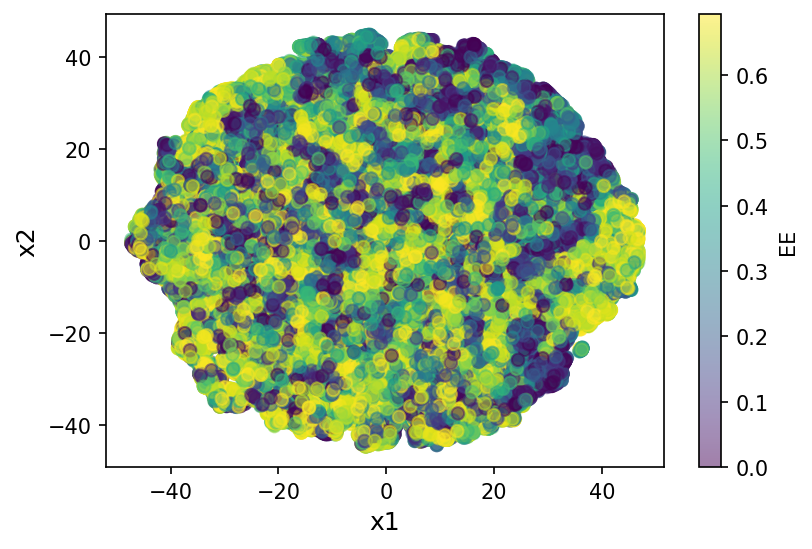

In [113]:
tsne = TSNE()
X_embedded = tsne.fit_transform(z_mean)
plot_scatter(X_embedded[:,0], X_embedded[:,1] , q2_ee,"x1","x2","EE", 0.5)

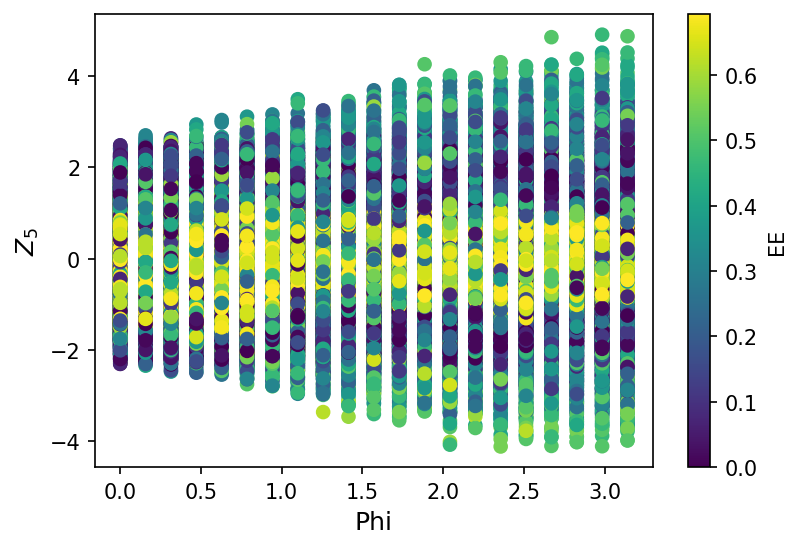

In [209]:
plot_scatter(y_test[:,1], z_mean[:,5] , q2_ee,"Phi","$Z_5$","EE",1)

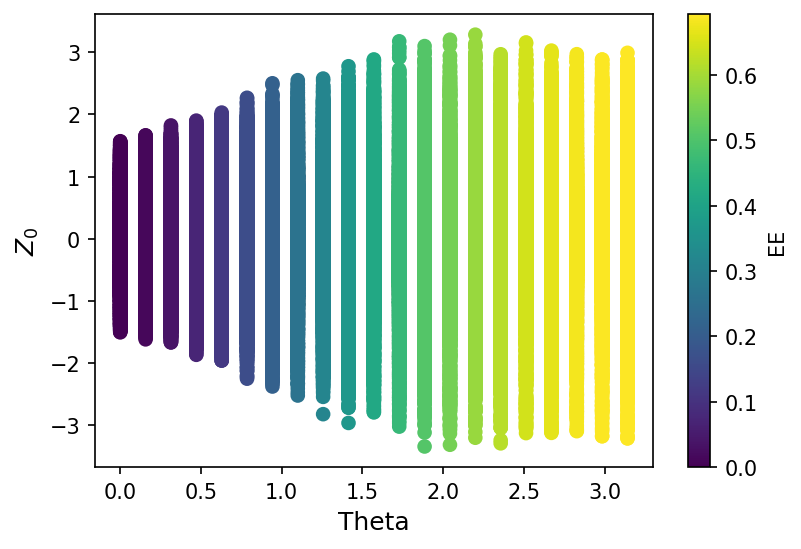

In [208]:
plot_scatter(y_test[:,0], z_mean[:,0] , q2_ee,"Theta","$Z_0$","EE",1)

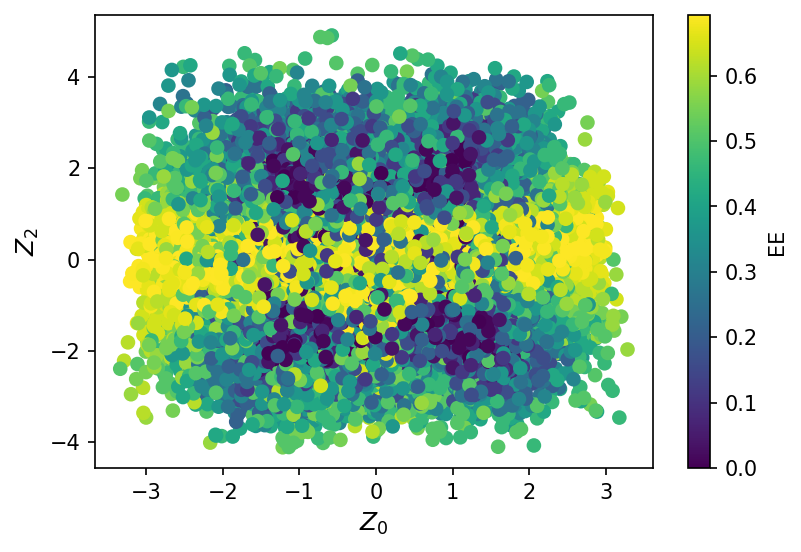

In [216]:
plot_scatter(z_mean[:,0], z_mean[:,5], q2_ee,"$Z_0$","$Z_2$","EE",1)

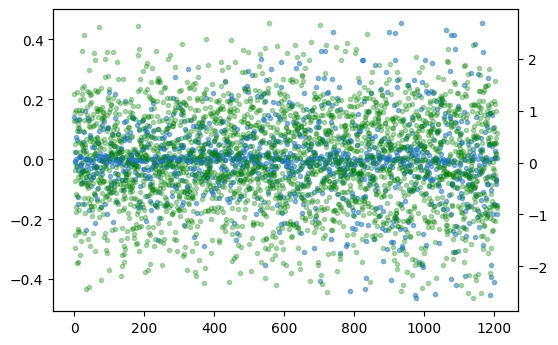

In [76]:
fig, ax1 = plt.subplots(dpi=100)
ax2 = ax1.twinx()
ax1.plot(test_rho[:,3], ".", alpha=0.5)
ax2.plot(z_mean,".g", alpha=0.3)
plt.show()

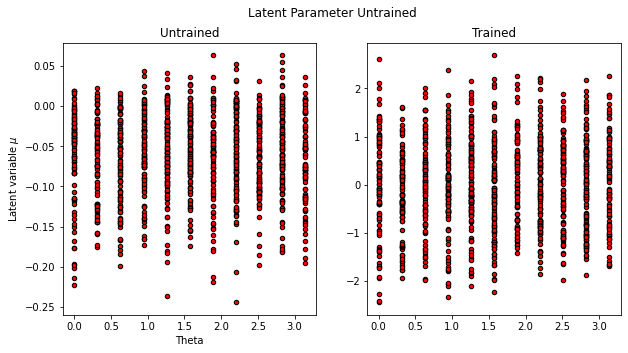

In [77]:
plot_lat_bef_aft(test_label[:,0], z_mean_untrained[:,0], z_mean[:,0], "Latent Parameter Untrained")

In [83]:
%%capture
n_exp = 4
lat_arr = [1,2,3,4]

final_loss_arr = np.zeros((n_exp, len(lat_arr)))
final_recon_loss_arr = np.zeros((n_exp, len(lat_arr)))
final_kl_loss_arr = np.zeros((n_exp, len(lat_arr)))


for exp in range(n_exp):
    for cnt, lat_dim in enumerate(lat_arr):
        b_s = 64
        beta = 0.1
        n_epoch = 150#45
        lr = 0.001
    
        hidden_act = "leaky_relu"
        final_act = "tanh"

        encoder, decoder = get_vae(lat_dim, hidden_act, final_act, False)
        vae = VAE(encoder, decoder, beta, "mse")
        vae.compile(optimizer=keras.optimizers.Adam(learning_rate=lr))
        history = vae.fit(train_rho, epochs=n_epoch, batch_size=b_s, verbose=0) 
        
        final_loss_arr[exp][cnt] = (history.history['loss'][-1])
        final_recon_loss_arr[exp][cnt] = (history.history['reconstruction_loss'][-1])
        final_kl_loss_arr[exp][cnt] = (history.history['kl_loss'][-1])
        

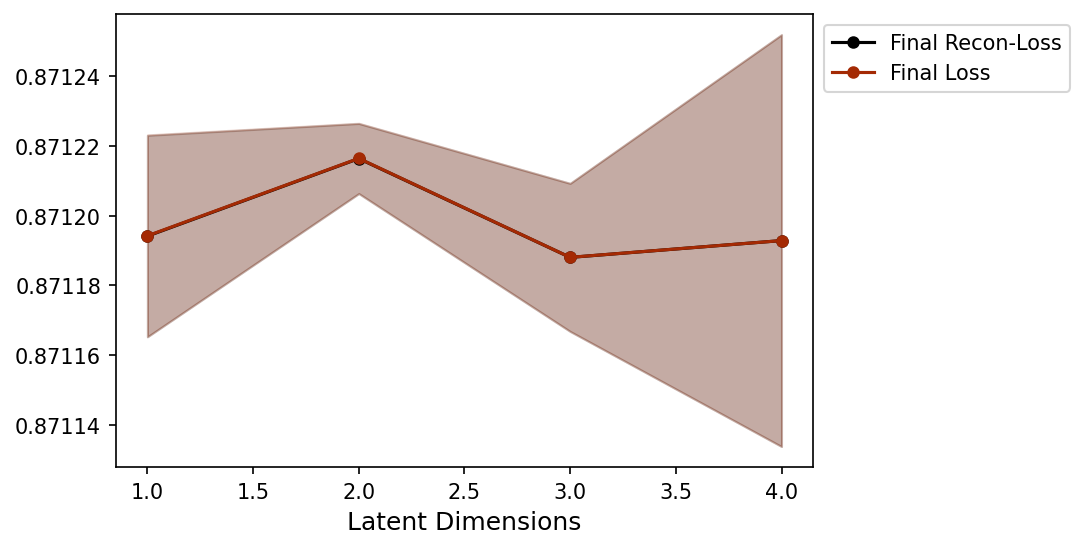

In [84]:
fig, ax = plt.subplots(dpi=150)
x_0 = np.average(final_kl_loss_arr,axis=0)
s_0 = np.std(final_kl_loss_arr,axis=0)
x_1 = np.average(final_recon_loss_arr,axis=0)
s_1 = np.std(final_recon_loss_arr,axis=0)
x_2 = np.average(final_loss_arr,axis=0)
s_2 = np.std(final_loss_arr,axis=0)


# ax.plot(lat_arr, x_0, label = "Average Fidelity",color="#003153", marker='o', markersize="5")
ax.plot(lat_arr, x_1, label = "Final Recon-Loss",c="black", marker='o', markersize="5")
ax.plot(lat_arr, x_2, label = "Final Loss", c="#A42A04", marker='o', markersize="5")

# plt.fill_between(lat_arr, x_0 - s_0, x_0 + s_0, alpha=0.2, color="#003153")
plt.fill_between(lat_arr, x_1 - s_1, x_1 + s_1, alpha=0.2, color="black")
plt.fill_between(lat_arr, x_2 - s_2, x_2 + s_2, alpha=0.2, color="#A42A04")

ax.set_xlabel("Latent Dimensions",fontsize=12)
#ax.set_ylabel("Entanglement Entropy",fontsize=12)
fig.legend(bbox_to_anchor=(0.9, 0.88), loc=2)
# fig.suptitle('Circuit', fontsize=16)

# Latent Space at different Beta

In [2]:
# n_points = 81
# n_samples = 7
# rho_arr = np.load('/home/felix/PycharmProjects/vae-wavefunctions/data/sic/unitary_8x8_81_7.npy', mmap_mode="r")
# scan_arr = np.linspace(0, np.pi, n_points)

n_points = 101
n_samples = 1000
rho_arr = np.load('/home/felix/PycharmProjects/vae-wavefunctions/data/sic/unitary_4x4_101_1000.npy', mmap_mode="r")
scan_arr = np.linspace(0, np.pi, n_points)

batch_size = 64
beta = 0.75
n_epoch = 1
learning_rate = 0.005
lat_dim = 2
# hidden_act = "leaky_relu"
# final_act = "tanh"

hidden_act = "tanh"
final_act = "linear"


theta_arr = np.zeros(len(rho_arr))
cnt = 0
for theta in scan_arr:
        for _ in (range(n_samples)):
            theta_arr[cnt] = theta
            cnt += 1

X_train, X_test, y_train, y_test = train_test_split(rho_arr, theta_arr, random_state=42)
q_ee = [ qt.entropy_vn(qt.Qobj(z0.reshape(4,4),dims=[[2,2],[2,2]]).ptrace(0)) for z0 in X_test]

In [57]:
inx_arr = ["01","02","03","04","05","06","07","08","09","1","11", "12"]
inx_arr = ["07","08","09","1","11", "12"]
inx_arr = ["06"]

inx_dict = {"001":0.01,"01":0.1,"02":0.2,"03":0.3,
            "04":0.4,"05":0.5,"06":0.6,"07":0.7,
            "08":0.8,"09":0.9,"10":1.0,"11":1.1, "12":1.2}


2/2 [==============================] - 1s 2ms/step - loss: 0.2649 - reconstruction_loss: 0.0368 - kl_loss: 0.3011
07


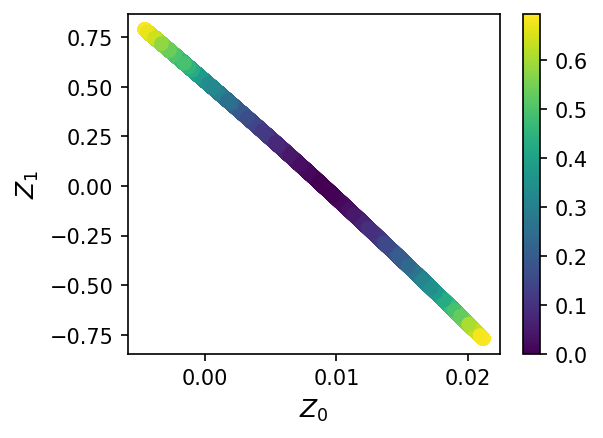

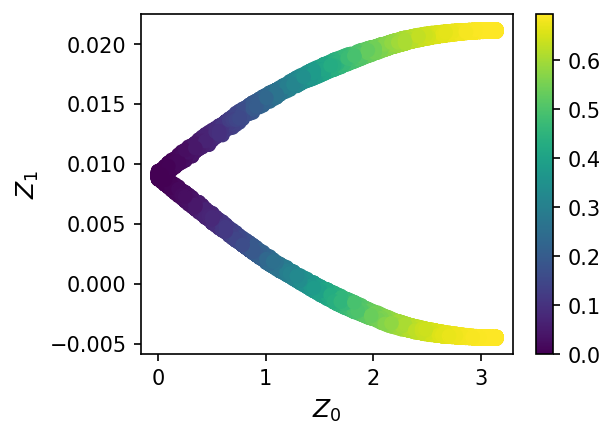

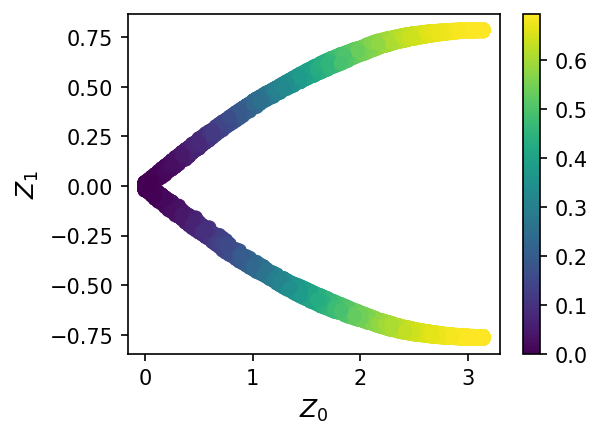

In [88]:
learning_rate = 0.005
lat_dim = 8
hidden_act = "tanh" 
final_act = "linear"



encoder, decoder = vae_mlp_4x4(lat_dim, hidden_act, final_act)

inx = "07"
beta = 0.7
encoder.load_weights("/home/felix/Downloads/leiden_cluster/dm4x4/grid_8/encoder_{}_grid_8.h5".format(inx))
decoder.load_weights("/home/felix/Downloads/leiden_cluster/dm4x4/grid_8/decoder_{}_grid_8.h5".format(inx))

vae = VAE(encoder, decoder, beta)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
vae.fit(X_test[:2], epochs=1, batch_size=1, verbose=1) 

z_mean, z_log_var, z = vae.encoder.predict(X_test)
gc.collect()
print(inx)
plot_scatter(z_mean[:,0],z_mean[:,1],q_ee,"$Z_0$","$Z_1$","",1)
plot_scatter(y_test,z_mean[:,0],q_ee,"$Z_0$","$Z_1$","",1)
plot_scatter(y_test,z_mean[:,1],q_ee,"$Z_0$","$Z_1$","",1)


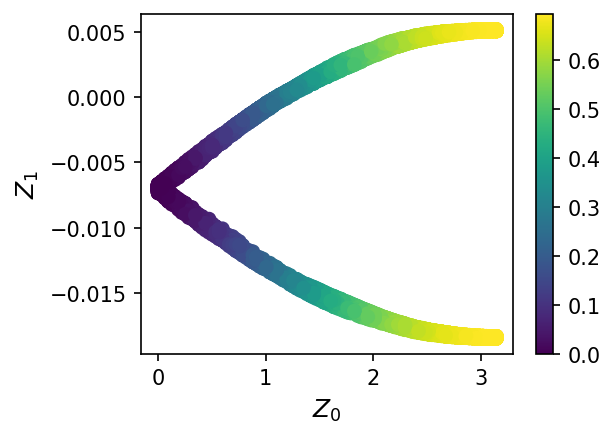

In [93]:
plot_scatter(y_test,z_mean[:,5],q_ee,"$Z_0$","$Z_1$","",1)

2/2 [==============================] - 1s 3ms/step - loss: 0.0834 - reconstruction_loss: 0.0036 - kl_loss: 7.9670
001


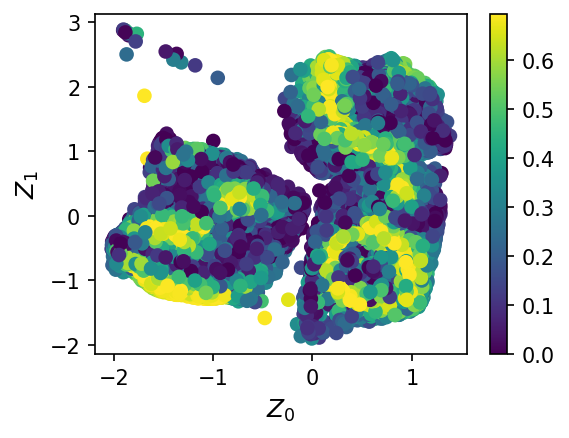

2/2 [==============================] - 1s 2ms/step - loss: 0.5209 - reconstruction_loss: 0.0102 - kl_loss: 5.1029
01


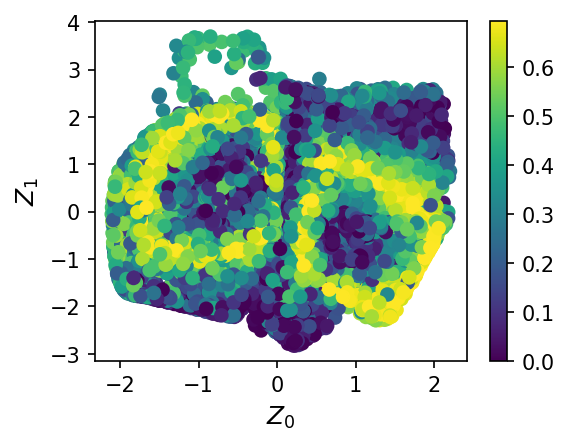

2/2 [==============================] - 1s 3ms/step - loss: 0.6066 - reconstruction_loss: 0.0130 - kl_loss: 3.0536
02


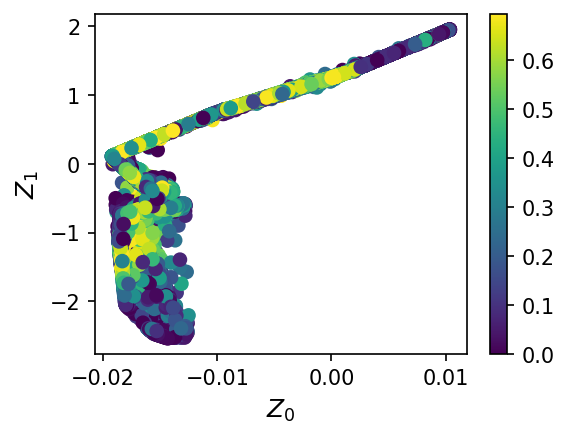

2/2 [==============================] - 1s 2ms/step - loss: 1.1953 - reconstruction_loss: 0.0137 - kl_loss: 3.8189
03


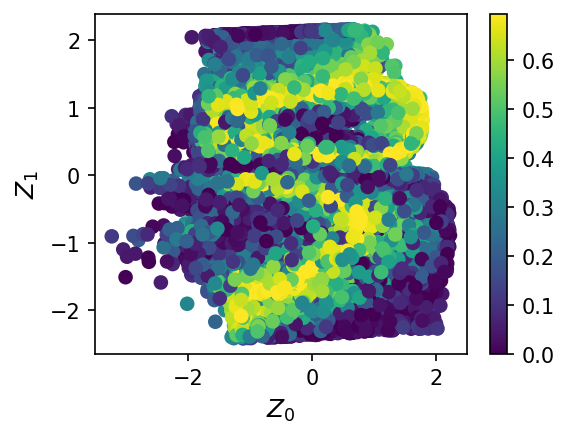

2/2 [==============================] - 1s 3ms/step - loss: 0.6960 - reconstruction_loss: 0.0348 - kl_loss: 1.4937
04


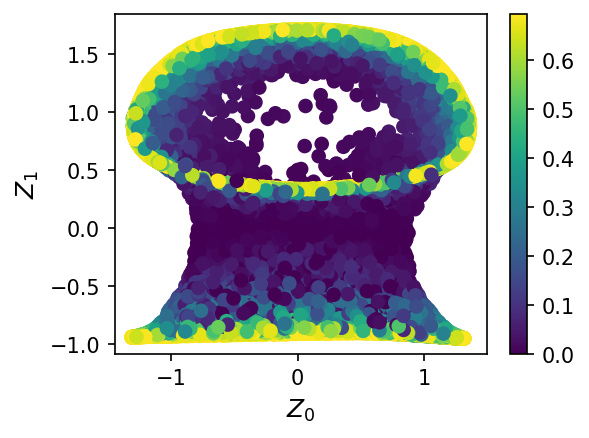

2/2 [==============================] - 1s 2ms/step - loss: 0.6990 - reconstruction_loss: 0.0284 - kl_loss: 1.2011
05


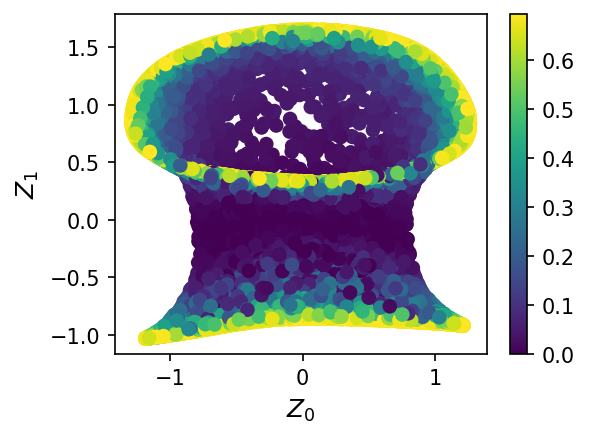

2/2 [==============================] - 1s 2ms/step - loss: 0.3504 - reconstruction_loss: 0.0381 - kl_loss: 0.5381
06


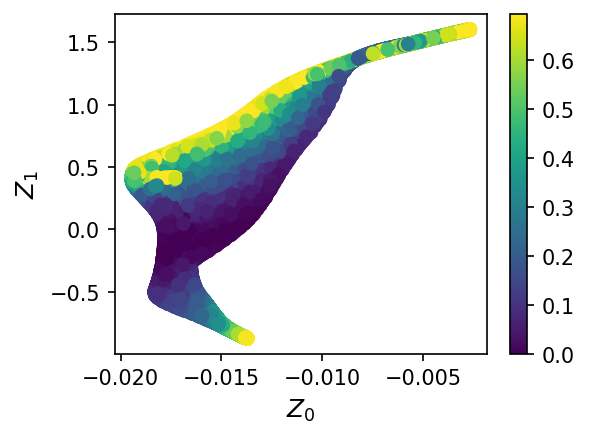

2/2 [==============================] - 1s 2ms/step - loss: 0.4367 - reconstruction_loss: 0.0380 - kl_loss: 0.5146
07


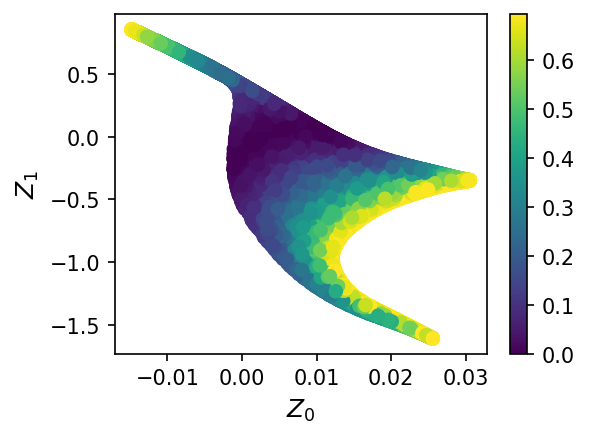

2/2 [==============================] - 1s 2ms/step - loss: 0.2179 - reconstruction_loss: 0.0518 - kl_loss: 0.1911
08


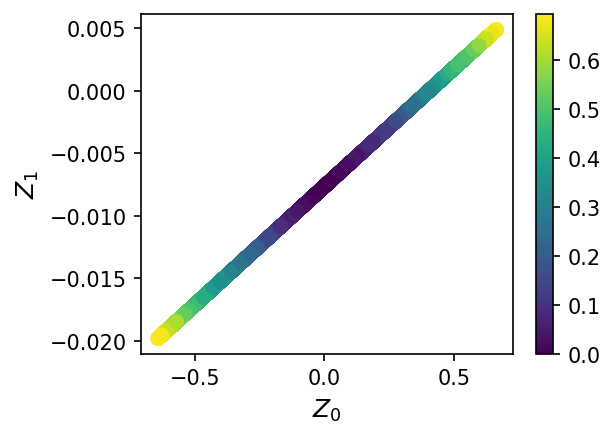

2/2 [==============================] - 1s 2ms/step - loss: 0.0470 - reconstruction_loss: 0.0471 - kl_loss: 6.4373e-06
09


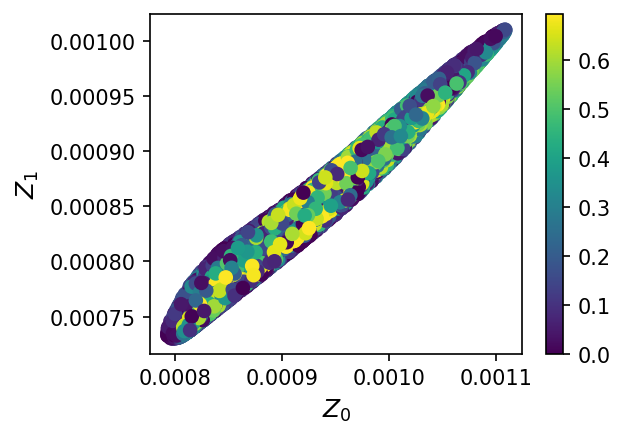

2/2 [==============================] - 1s 4ms/step - loss: 0.0471 - reconstruction_loss: 0.0471 - kl_loss: 8.0764e-06
10


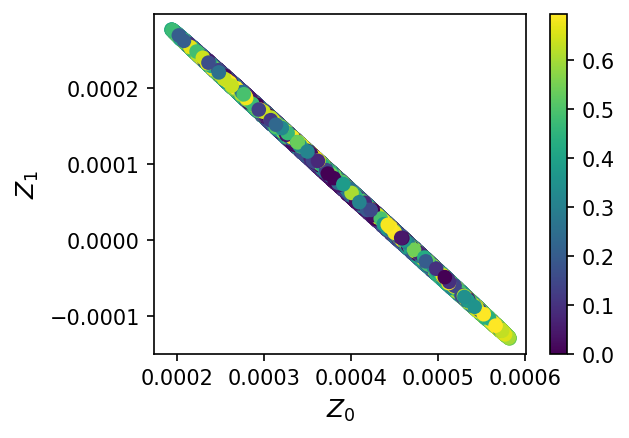

2/2 [==============================] - 1s 2ms/step - loss: 0.0470 - reconstruction_loss: 0.0471 - kl_loss: 1.1623e-06
11


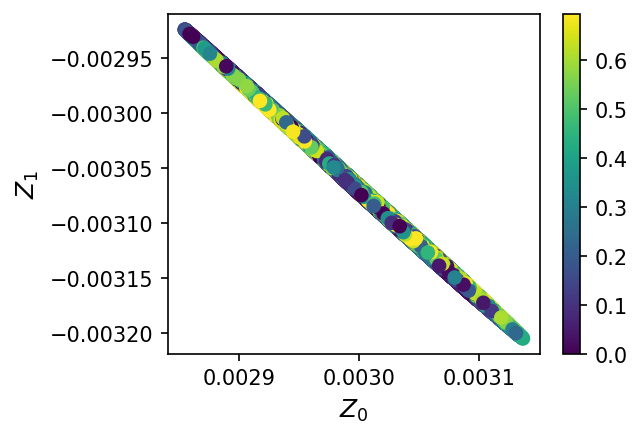

2/2 [==============================] - 1s 2ms/step - loss: 0.0471 - reconstruction_loss: 0.0471 - kl_loss: 2.0847e-04
12


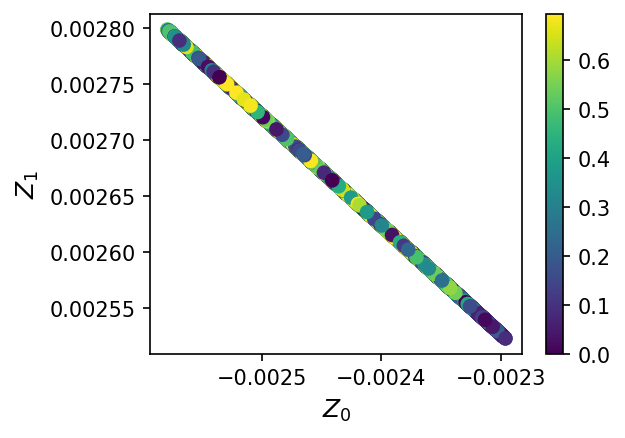

In [58]:
learning_rate = 0.005
lat_dim = 2
hidden_act = "tanh" 
final_act = "linear"

for inx,beta in inx_dict.items():

    encoder, decoder = vae_mlp_4x4(lat_dim, hidden_act, final_act)
#     encoder.load_weights("/home/felix/Downloads/leiden_cluster/dm4x4/noise_multiple_beta/encoder_2_{}_mlp.h5".format(inx))
#     decoder.load_weights("/home/felix/Downloads/leiden_cluster/dm4x4/noise_multiple_beta/decoder_2_{}_mlp.h5".format(inx))

    encoder.load_weights("/home/felix/Downloads/leiden_cluster/dm4x4/grid_2/encoder_{}_grid_2.h5".format(inx))
    decoder.load_weights("/home/felix/Downloads/leiden_cluster/dm4x4/grid_2/decoder_{}_grid_2.h5".format(inx))

    

    vae = VAE(encoder, decoder, beta)
    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    vae.fit(X_test[:2], epochs=1, batch_size=1, verbose=1) 

    z_mean, z_log_var, z = vae.encoder.predict(X_test)
    gc.collect()
    print(inx)
    plot_scatter(z_mean[:,0],z_mean[:,1],q_ee,"$Z_0$","$Z_1$","",1)
#     fig, ax = plt.subplots(dpi=150,projection='3d')
#     im = ax.scatter(z_mean[:,0], z_mean[:,1],q_ee, c=q_ee, alpha=1)
# #     ax.set_xlabel(title_x, fontsize=12)
# #     ax.set_ylabel(title_y, fontsize=12)
# #     cbar = fig.colorbar(im)
# #     cbar.set_label(title_cbar)
      
#     plt.xticks([])
#     plt.yticks([])
# #     plt.tight_layout()
# #     ax.set_aspect('equal', adjustable='box')
#     ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
    
#     plt.show() 
# #     plt.savefig("/home/felix/Downloads/leiden_cluster/dm4x4/noise_multiple_beta/4x4_noise_latent_{}.png".format(inx))
# #     except:
# #         1
# #         print("here")

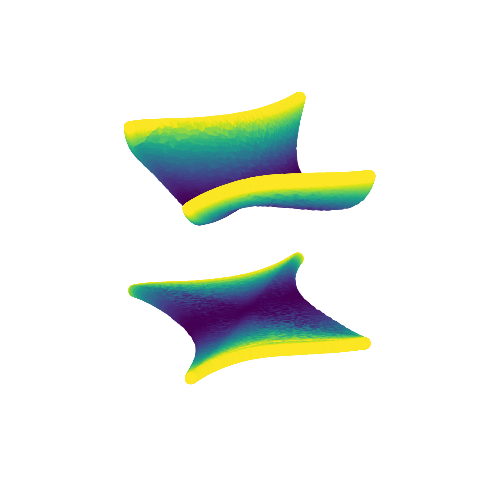

In [114]:
fig = plt.figure(dpi = 150)
ax = fig.add_subplot(projection='3d')

inx = 10

ax.scatter(z_mean[:,0], z_mean[:,1],5*np.array(q_ee), c= q_ee,alpha=1)

# ax2 = ax.twinz()
ax.scatter(z_mean[:,0], z_mean[:,1],np.zeros(len(q_ee))-10, c= q_ee,alpha=1)
# ax.scatter(z_mean[:,0][inx], z_mean[:,1][inx],q_ee[inx], c= "black", marker="^")


# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_zticks([])
ax.axis("off")

# plt.show() 
plt.savefig("/home/felix/Downloads/3d_lat",transparent=True)

In [151]:
n_points = 101
n_samples = 1000
rho_arr = np.load('/home/felix/PycharmProjects/vae-wavefunctions/data/sic/unitary_4x4_101_1000.npy', mmap_mode="r")
scan_arr = np.linspace(0, np.pi, n_points)

batch_size = 64
beta = 0.75
n_epoch = 1
learning_rate = 0.005
lat_dim = 2
# hidden_act = "leaky_relu"
# final_act = "tanh"

hidden_act = "tanh"
final_act = "linear"


theta_arr = np.zeros(len(rho_arr))
cnt = 0
for theta in scan_arr:
        for _ in (range(n_samples)):
            theta_arr[cnt] = theta
            cnt += 1

X_train, X_test, y_train, y_test = train_test_split(rho_arr, theta_arr, random_state=42)
q_ee = [ qt.entropy_vn(qt.Qobj(z0.reshape(4,4),dims=[[2,2],[2,2]]).ptrace(0)) for z0 in X_test]

In [152]:
# inx_arr = ["104","1045","103","1035","102","1025","101","1015","075","100"]
# beta_arr = [10**-4,5*10**-4,10**-3,5*10**-3,10**-2,5*10**-2,10**-1,5*10**-1,0.75, 10**0]

inx_arr = ["005","01","02","035","04","05","06","075","08","09"]
beta_arr = [0.05,0.1,0.2,0.35,0.4,0.5,0.6,0.75,0.8,0.9]



In [63]:
def kl_loss(mu,sig):
    return -0.5 * (1 + sig - mu**2 - np.exp(sig))

In [77]:

learning_rate = 0.005
lat_dim = 8
kl_arr = np.zeros((len(inx_dict),lat_dim))
hidden_act = "tanh" 
final_act = "linear"

cnt = 0 
for inx,beta in inx_dict.items():

    encoder, decoder = vae_mlp_4x4(lat_dim, hidden_act, final_act)
#     encoder.load_weights("/home/felix/Downloads/leiden_cluster/dm4x4/plot/encoder_8_{}_mlp.h5".format(inx))
#     decoder.load_weights("/home/felix/Downloads/leiden_cluster/dm4x4/plot/decoder_8_{}_mlp.h5".format(inx))

    encoder.load_weights("/home/felix/Downloads/leiden_cluster/dm4x4/grid_8/encoder_{}_grid_8.h5".format(inx))
    decoder.load_weights("/home/felix/Downloads/leiden_cluster/dm4x4/grid_8/decoder_{}_grid_8.h5".format(inx))
    
    vae = VAE(encoder, decoder, beta)
    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    vae.fit(X_test[:2], epochs=1, batch_size=1, verbose=0) 

    z_mean, z_log_var, z = vae.encoder.predict(X_test)
    gc.collect()

    for i in range(lat_dim):
        kl_arr[cnt][i] = np.average(kl_loss(z_mean[:,i], z_log_var[:,i]))
    cnt += 1 
        

In [78]:
row_sums = np.sort(kl_arr,axis=-1).sum(axis=1)
new_matrix = np.sort(kl_arr,axis=-1) / row_sums[:, np.newaxis]

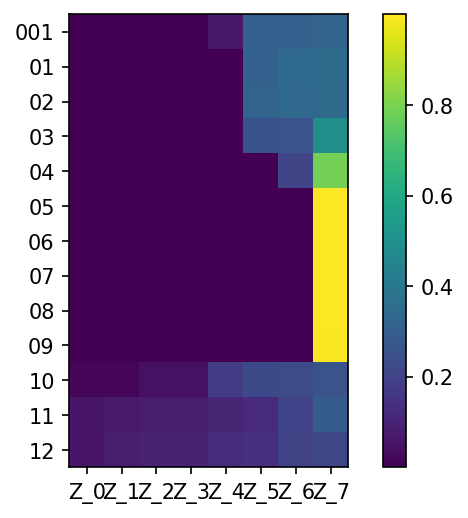

In [79]:
fig, ax = plt.subplots(dpi=150)
im = ax.imshow(new_matrix)
cbar = fig.colorbar(im)
cbar.set_label("")
plt.xticks(range(lat_dim),["Z_{}".format(i) for i in range(lat_dim)])
plt.yticks(range(len(inx_dict)),inx_dict)
plt.show()

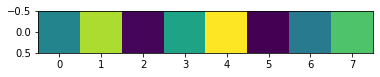

In [157]:
plt.imshow([kl_arr[-1]])

In [80]:
loss_arr = np.zeros((len(inx_dict), 1000))
recon_loss_arr = np.zeros((len(inx_dict), 1000))
kl_loss_arr = np.zeros((len(inx_dict), 1000))

for cnt_1, inx in enumerate(inx_dict.keys()):
        read_dictionary = np.load('/home/felix/Downloads/leiden_cluster/dm4x4/grid_8/history_{}_grid_8.npy'.format(inx),allow_pickle='TRUE').item()
        recon_loss_arr[cnt_1] = read_dictionary["reconstruction_loss"]
        kl_loss_arr[cnt_1] = read_dictionary["kl_loss"]
        


# for cnt, i in enumerate(av_recon_loss_arr):
#     ax.plot(i, label = cnt+1, marker='o', markersize="5")
#     ax.fill_between(np.arange(1000), i - std_recon_loss_arr[cnt], i + std_recon_loss_arr[cnt], alpha=0.2)
# ax.set_xlabel("Epoch",fontsize=12)
# ax.set_ylabel("Reconstruction Loss",fontsize=12)
# fig.legend(bbox_to_anchor=(0.9, 0.88), loc=2)
# # ax.set_title("4x4 noise varying Latent Variable")  
# ax.set_yscale("log")

Text(0, 0.5, 'recon loss')

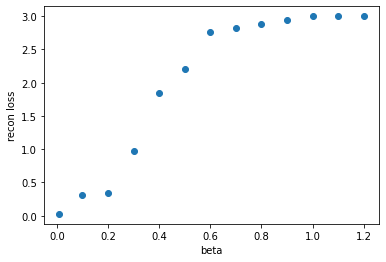

In [94]:
plt.scatter(list(inx_dict.values()), recon_loss_arr[:,-1])
# plt.xscale("log")
# plt.yscale("log")
plt.xlabel("beta")
plt.ylabel("recon loss")

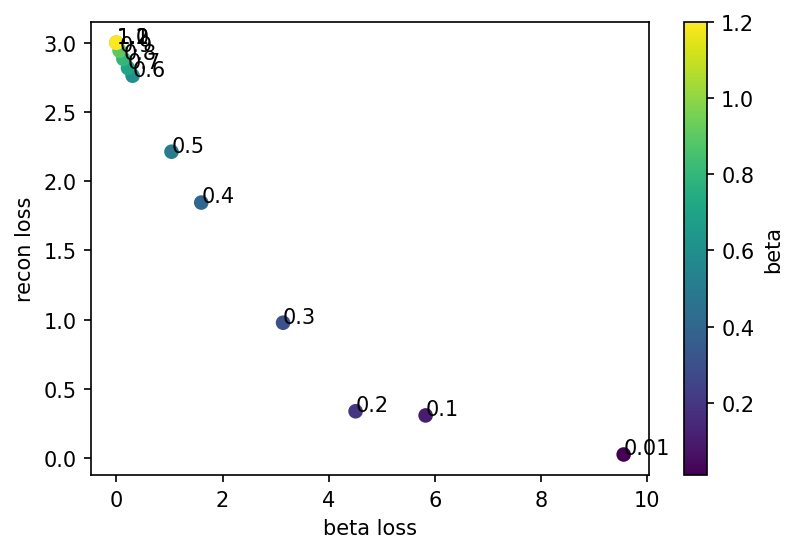

In [83]:
fig, ax = plt.subplots(dpi=150)
im = ax.scatter(kl_loss_arr[:,-1], recon_loss_arr[:,-1], c=list(inx_dict.values()))
cbar = fig.colorbar(im)
cbar.set_label("beta")
# plt.xscale("log")
# plt.yscale("log")
plt.xlabel("beta loss")
plt.ylabel("recon loss")


for i, txt in enumerate(inx_dict.values()):
    ax.annotate(txt, (kl_loss_arr[:,-1][i], recon_loss_arr[:,-1][i]))

plt.show()

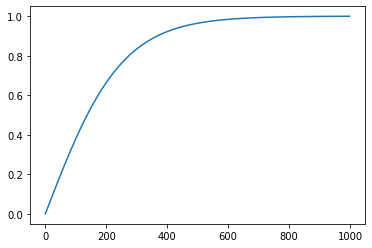

In [164]:
plt.plot([np.tanh(2*i/500) for i in range(1000)])